# DSA5105 ML Project

# Outline
- [ 1 - Big Picture ](#1)
    - [data description](#1.1)
    - [problem statement and objective](#1.2)
- [ 2 -  Setup](#2)
    - [packages](#2.1)
    - [datasets](#2.2)
- [ 3 - EDA](#3)
    - [individual distributions](#3.1)
    - [correlation](#3.2)
        - [numerical features vs target](#3.3)
        - [categorical features vs target](#3.4)
        - [feature combinations](#3.5)
- [ 4 - Preprocessing](#4)
- [ 5 - Modeling](#5)
    - [baseline models](#5.1)
    - [hyperparameter tuning](#5.2)
- [6 - Resampling](#6)
    - [random oversampling](#6.1)
    - [random downsampling](#6.2)
    - [SMOTE](#6.3)

<a name="1"></a>
# 1 - The big picture

## Data description<a name="1.1"></a>

- The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be (or not) subscribed. ([Moro et al., 2011])


- There are 45,211 instances for bank-full.csv, including 36,169 training data and 9,042 test data. Both data contain 16 input variables + 1 target variable.


### Attribute information:

##### bank client data
    1. age (numeric)
    2. job: type of job ("admin.","unknown","unemployed","management","housemaid","entrepreneur","student",
       "blue-collar","self-employed","retired","technician","services") 
    3. marital: marital status ("married","divorced","single"; note: "divorced" means divorced or widowed)
    4. education: ("unknown","secondary","primary","tertiary")
    5. default: has credit in default? (binary: "yes","no")
    6. balance: average yearly balance, in euros (numeric) 
    7. housing: has housing loan? (binary: "yes","no")
    8. loan: has personal loan? (binary: "yes","no")
##### related with the last contact of the current campaign:
    9. contact: contact communication type (categorical: "unknown","telephone","cellular") 
    10. day: last contact day of the month (numeric)
    11. month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")
    12. duration: last contact duration, in seconds (numeric)
##### other attributes:
    13. campaign: number of contacts performed during this campaign for this client(numeric, includes last contact)
    14. pdays: number of days passed by after the client was last contacted from previous campaign 
        (numeric, -1 means client was not previously contacted)
    15. previous: number of contacts performed before this campaign and for this client (numeric)
    16. poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")
##### output variable (desired target):
    17. y - has the client subscribed a term deposit? (binary: "yes","no")


## Problem statement and objective
This is a classification task where we want to predict if the client will subscribe a term deposit (`y=1`).

Due to the skewed nature of the classes, our objective will be to achieve a higher recall and precision on the positive class.

<a name="2"></a>
# 2 - Set up

## packages <a name="2.1"></a>

In [2]:
# import libraries and run a few checks
import sys
assert sys.version_info >= (3, 5)

import sklearn
assert sklearn.__version__ >= "0.20"

import numpy as np
import pandas as pd
import os

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

import seaborn as sns
sns.set(palette='Paired', style='white')

import warnings 
warnings.filterwarnings('ignore')

# Where to save the figures
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

# utility function to save figures for presentation
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## datasets <a name="2.2"></a>

In [3]:
train = pd.read_csv('traininingdata.txt', sep=';')
test = pd.read_csv('testdata.txt', sep=';')

In [4]:
train.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,42,technician,divorced,secondary,no,-78,yes,yes,cellular,29,jul,10,23,-1,0,unknown,no
1,50,management,married,tertiary,no,106,yes,no,unknown,15,may,388,2,-1,0,unknown,no
2,47,admin.,married,secondary,no,407,yes,no,unknown,5,jun,67,12,-1,0,unknown,no
3,39,admin.,divorced,secondary,no,952,yes,no,unknown,16,jun,62,1,-1,0,unknown,no
4,30,management,single,tertiary,no,364,no,no,cellular,30,apr,306,2,-1,0,unknown,yes


In [5]:
train['y'].replace({'yes': 1, 'no': 0}, inplace=True)
test['y'].replace({'yes': 1, 'no': 0}, inplace=True)

Let us see how imbalanced the data is.

In [6]:
total = len(train)
neg, pos = np.bincount(train['y'])
print(f'Examples: {total}\n    negative: {neg}\n    positive: {pos} ({pos/total:.2%})')

Examples: 36168
    negative: 31937
    positive: 4231 (11.70%)


<a name='3'></a>
# 3 - EDA

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36168 entries, 0 to 36167
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        36168 non-null  int64 
 1   job        36168 non-null  object
 2   marital    36168 non-null  object
 3   education  36168 non-null  object
 4   default    36168 non-null  object
 5   balance    36168 non-null  int64 
 6   housing    36168 non-null  object
 7   loan       36168 non-null  object
 8   contact    36168 non-null  object
 9   day        36168 non-null  int64 
 10  month      36168 non-null  object
 11  duration   36168 non-null  int64 
 12  campaign   36168 non-null  int64 
 13  pdays      36168 non-null  int64 
 14  previous   36168 non-null  int64 
 15  poutcome   36168 non-null  object
 16  y          36168 non-null  int64 
dtypes: int64(8), object(9)
memory usage: 4.7+ MB


No missing data.

In [8]:
# numerical columns
num_cols = train.describe().columns.to_list()[:-1]
train.describe()

,age,balance,day,duration,campaign,pdays,previous,y
count,36168.000000,36168.000000,36168.000000,36168.000000,36168.000000,36168.000000,36168.000000,36168.000000
mean,40.942076,1365.055989,15.778534,258.363166,2.769907,39.749889,0.579601,0.116982
std,10.616610,3098.191637,8.313360,257.188052,3.119367,99.547099,2.384831,0.321403
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000,0.000000
75%,48.000000,1422.250000,21.000000,320.000000,3.000000,-1.000000,0.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000,1.000000


Only 11.7% customers subscribed a term deposite, meaning highly imbalanced classes.

In [9]:
# non-numerical columns
cat_cols = train.describe(include=['O']).columns.to_list()
train.describe(include=['O'])

,job,marital,education,default,housing,loan,contact,month,poutcome
count,36168,36168,36168,36168,36168,36168,36168,36168,36168
unique,12,3,4,2,2,2,3,12,4
top,blue-collar,married,secondary,no,yes,no,cellular,may,unknown
freq,7804,21795,18556,35518,20031,30399,23380,11034,29623


## Invidual distributions <a name="3.1"></a>

For numerical features, let's examine each histogram to understand the distribution.

In [11]:
for col, ax in zip(num_cols, axes.flat):
    print(col)

age
balance
day
duration
campaign
pdays
previous


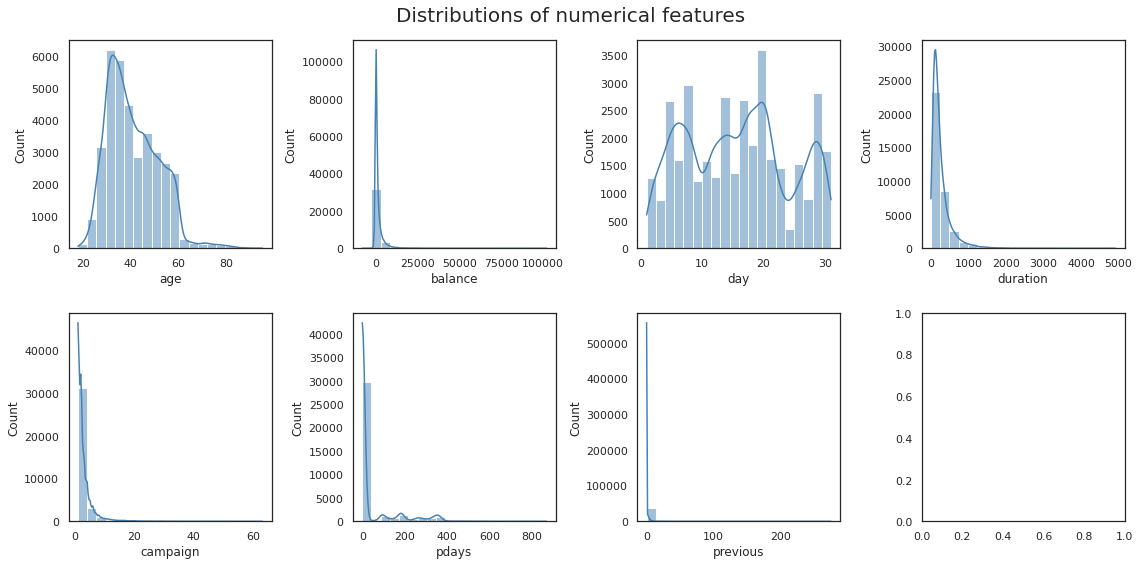

In [10]:
# numerical features
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))
for col, ax in zip(num_cols, axes.flat):
    sns.histplot(x=col, data=train, bins=20, kde=True, ax=ax, color='steelblue')
fig.suptitle('Distributions of numerical features', fontsize=20)
plt.tight_layout(h_pad=2)

#save_fig("num_cols_distribution_plots")

> for highly skewed features, consider log transformation to give a more normal semblance

For categorical features, let's plot countplot to understand each distribution.

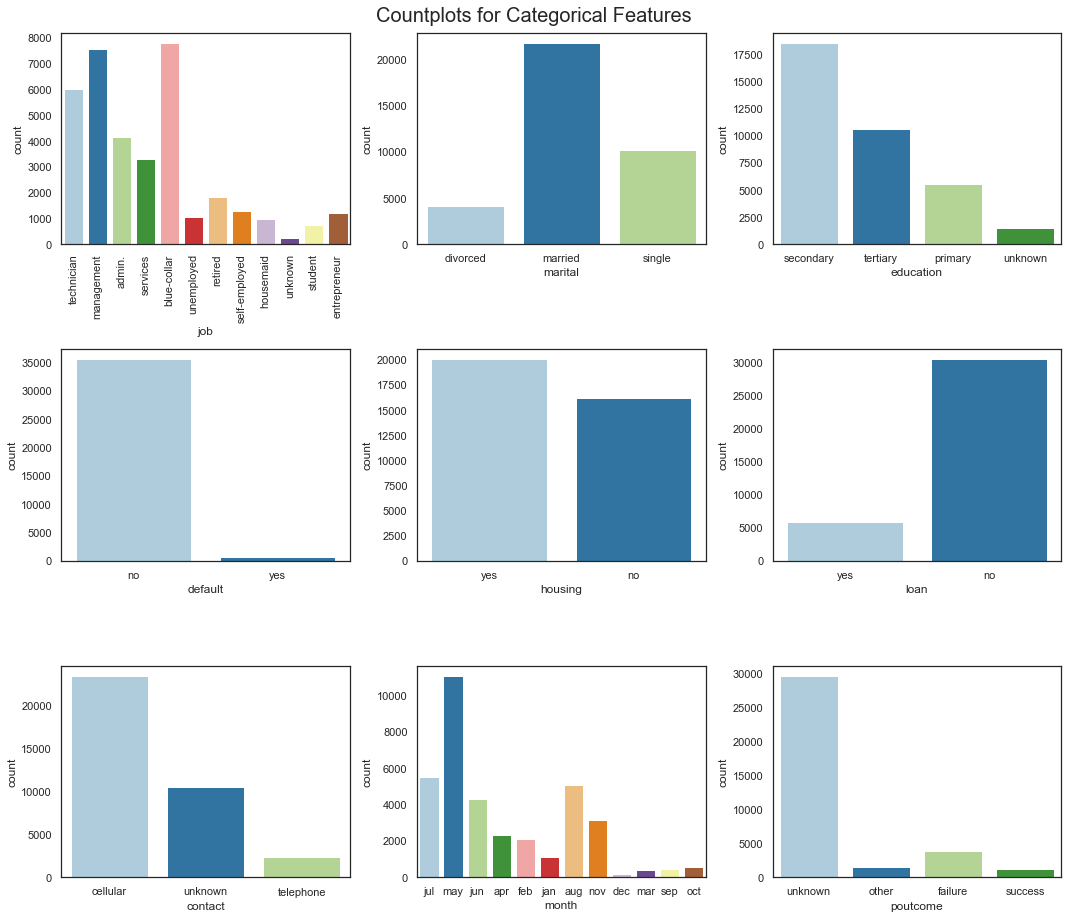

In [12]:
# categorical features
sns.set_palette('Paired')
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 13))
for i, ax in enumerate(axes.flat):
    sns.countplot(x=train[cat_cols[i]], ax=ax)
    if cat_cols[i] == 'job':
        ax.tick_params(axis='x', labelrotation=90)
fig.suptitle('Countplots for Categorical Features', fontsize=20)
plt.tight_layout()
#train[num_cols].hist(bins=30, figsize=(15,12))
#save_fig("cat_cols_distribution_plots")

Finally, our target variable.

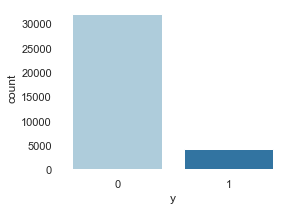

In [13]:
# target variable: very unbalanced, about 10% are positive
fig, ax = plt.subplots(figsize=(4, 3))
sns.countplot(x=train['y'], ax=ax)
sns.despine(left=True, bottom=True);

## Correlations<a name="3.2"></a>

### What are the correlation between numerical features?

In [14]:
# check correlations between numerical features
corrT = train[num_cols + ['y']].corr()
corrT

,age,balance,day,duration,campaign,pdays,previous,y
age,1.000000,0.093403,-0.008967,-0.003116,0.000354,-0.022179,0.001556,0.021976
balance,0.093403,1.000000,0.007385,0.022069,-0.014053,0.004141,0.017863,0.048057
day,-0.008967,0.007385,1.000000,-0.030053,0.163619,-0.091943,-0.051983,-0.030527
duration,-0.003116,0.022069,-0.030053,1.000000,-0.086969,0.000291,0.002381,0.401466
campaign,0.000354,-0.014053,0.163619,-0.086969,1.000000,-0.089526,-0.033579,-0.072407
pdays,-0.022179,0.004141,-0.091943,0.000291,-0.089526,1.000000,0.437361,0.106851
previous,0.001556,0.017863,-0.051983,0.002381,-0.033579,0.437361,1.000000,0.088729
y,0.021976,0.048057,-0.030527,0.401466,-0.072407,0.106851,0.088729,1.000000


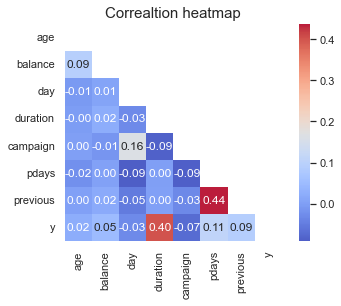

In [15]:
# heatmap of correlation
mask = np.zeros_like(corrT, dtype=bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corrT, annot=True, fmt = '.2f',square=True, cmap='coolwarm', mask=mask, alpha=0.9)
plt.title('Correaltion heatmap', fontsize=15);

- **duration** and target **y** are positively correlated, which is intuitive
- **previous** and **pdays** are positively correlated, this might have something to do with the campaign strategy

### How does each numerical feature correlate with target? <a name="3.3"></a>

In [16]:
pd.pivot_table(train, index='y', values=num_cols)

,age,balance,campaign,day,duration,pdays,previous
y,,,,,,,
0,40.857156,1310.864702,2.852115,15.870902,220.782196,35.878417,0.502583
1,41.583077,1774.109903,2.149374,15.081305,542.036871,68.973056,1.160955


From the looks of it, it seems like except for age and day, the rest of the features seem to have some distinguishing power over target.

Let's closely examine each numerical feature vs target variable.

### age vs y

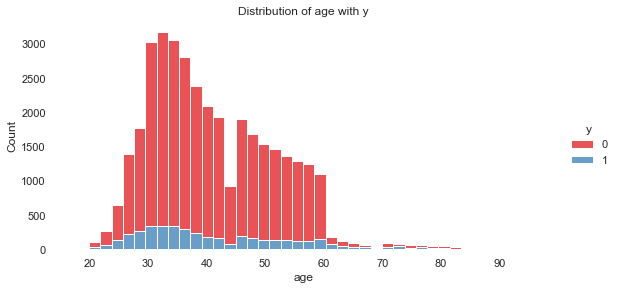

In [17]:
sns.displot(data=train, kind='hist', x='age', hue='y', bins=40,
            multiple='stack', height=4, aspect=2, palette='Set1')
sns.despine(left=True, bottom=True)
plt.title('Distribution of age with y');

In [ ]:
# try discretize age into groups
min_age = train.age.min()
max_age = train.age.max()
train['age_group'] = pd.cut(train.age, bins=[min_age-1, 30, 35, 40, 45, 50, 55, 60, max_age+1])

# check out each age group's size and proportion of subscribing (y=1)
age_group = train.pivot_table(index='age_group', values='y', aggfunc=[np.size, np.mean]).reset_index()
age_group.columns = ['age_group', 'size', 'proportion of yes']
age_group

,age_group,size,proportion of yes
0,"(17, 30]",5636,0.162881
1,"(30, 35]",7852,0.106724
2,"(35, 40]",6287,0.098934
3,"(40, 45]",4833,0.086903
4,"(45, 50]",4160,0.093029
5,"(50, 55]",3485,0.095552
6,"(55, 60]",2977,0.109506
7,"(60, 96]",938,0.412580


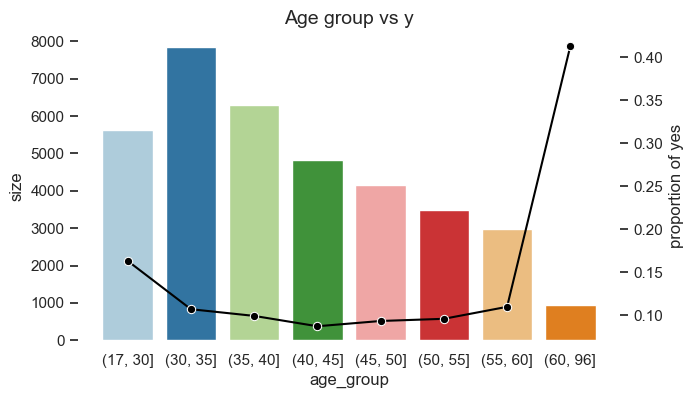

In [ ]:
# visualization of age_group
fig, ax1 = plt.subplots(figsize=(7, 4))
sns.barplot(data=age_group, x='age_group', y='size', ax=ax1)
ax2 = ax1.twinx()
sns.lineplot(data=age_group['proportion of yes'], marker='o', color='black', sort = False, ax=ax2)
sns.despine(left=True, bottom=True)
plt.title('Age group vs y', fontsize=14);

**Insights**
- Interestingly, the age groups on the two extreme ends of the spectrum seem to have better chances of subscribing to the term deposit, while the age groups in the middle have relatively lower proportion of people subscribing the product. 

- Moreover, we see that as age group goes up, the size generally goes down.

- *Possible strategy suggestion: maybe we should invest more resources on the extreme ends of the spectrum, i.e. targeting people in the age group below 30 and above 55.*

### balance vs y

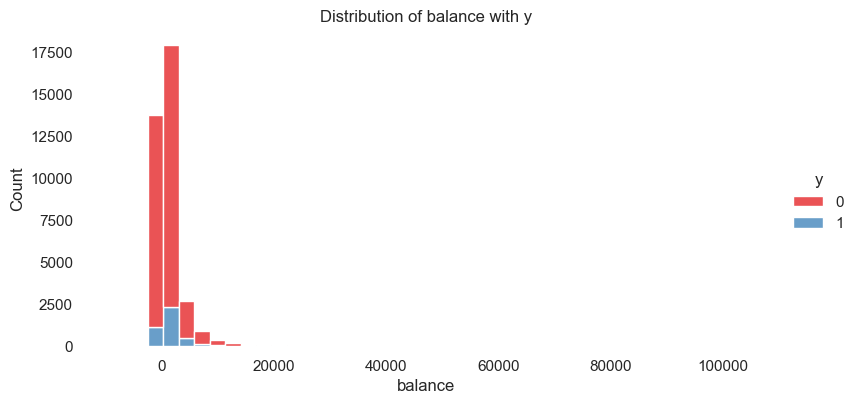

In [ ]:
sns.displot(data=train, kind='hist', x='balance', hue='y', bins=40,
            multiple='stack', height=4, aspect=2, palette='Set1')
sns.despine(left=True, bottom=True)
plt.title('Distribution of balance with y');

In [ ]:
# it's a bit hard to visualize the relationship between y and balance, let's try binning again
train['balance_group'] = pd.cut(train.balance, bins=[float('-inf'), 0, 100, 500, 1500, float('inf')])
balance_group = train.pivot_table(index='balance_group', values='y', aggfunc=[np.size, np.mean]).reset_index()
balance_group.columns = ['balance_group', 'size', 'proportion of yes']
balance_group

,balance_group,size,proportion of yes
0,"(-inf, 0.0]",5805,0.068045
1,"(0.0, 100.0]",4190,0.079475
2,"(100.0, 500.0]",8936,0.114033
3,"(500.0, 1500.0]",8543,0.127005
4,"(1500.0, inf]",8694,0.160916


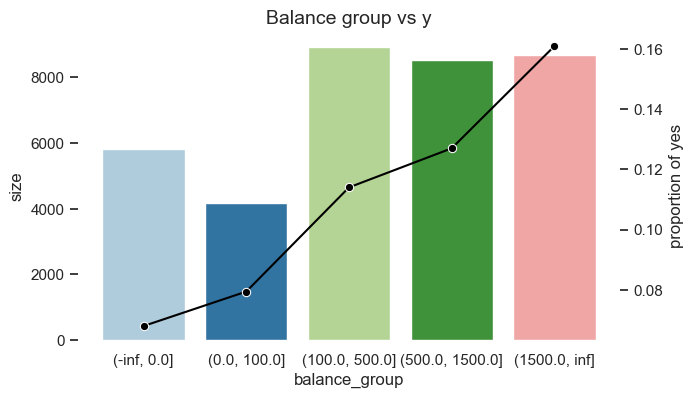

In [ ]:
# visualization of balance_group
fig, ax1 = plt.subplots(figsize=(7, 4))
sns.barplot(data=balance_group, x='balance_group', y='size', ax=ax1)
ax2 = ax1.twinx()
sns.lineplot(data=balance_group['proportion of yes'], marker='o', color='black', sort = False, ax=ax2)
sns.despine(left=True, bottom=True)
plt.title('Balance group vs y', fontsize=14);

Intuitively, the more balance, the more likely to subscribe to a term deposit.

### day vs y

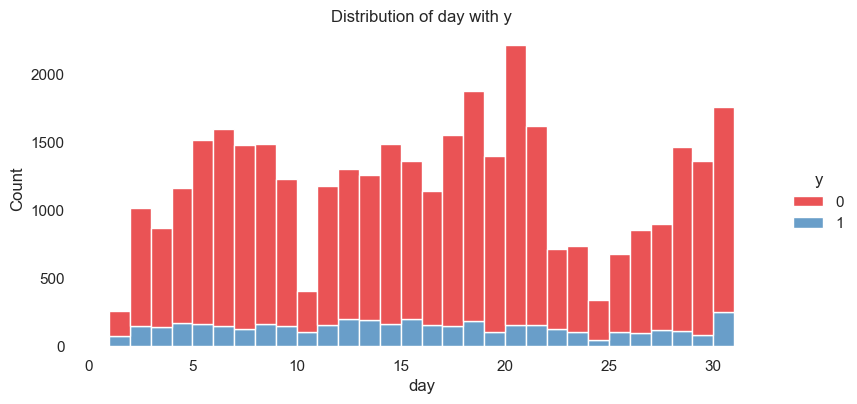

In [ ]:
sns.displot(data=train, kind='hist', x='day', hue='y', bins=30,
            multiple='stack', height=4, aspect=2, palette='Set1')
sns.despine(left=True, bottom=True)
plt.title('Distribution of day with y');

Seems like day is not informative of target y.

### duration vs y

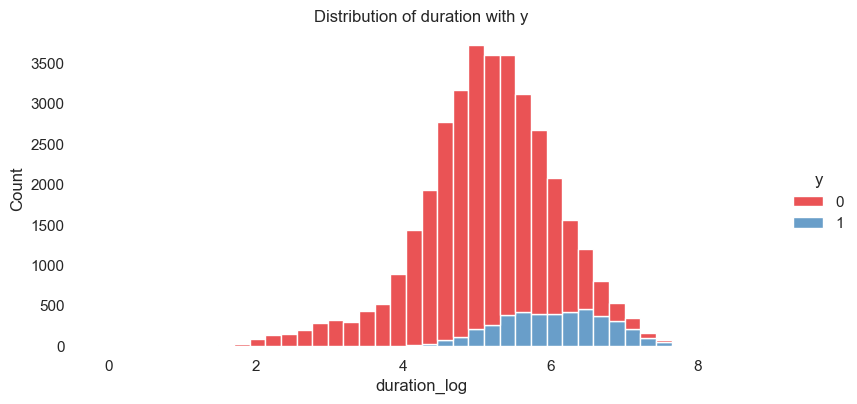

In [ ]:
# duration is skewed to the right, apply np.log1p to give a more normal semblance
train['duration_log'] = train['duration'].apply(np.log1p)
sns.displot(data=train, kind='hist', x='duration_log', hue='y', bins=40,
            multiple='stack', height=4, aspect=2, palette='Set1')
sns.despine(left=True, bottom=True)
plt.title('Distribution of duration with y');

As expected, the longer duration of the last contact, the more likely to subscribe

### campaign (number of contacts) vs y

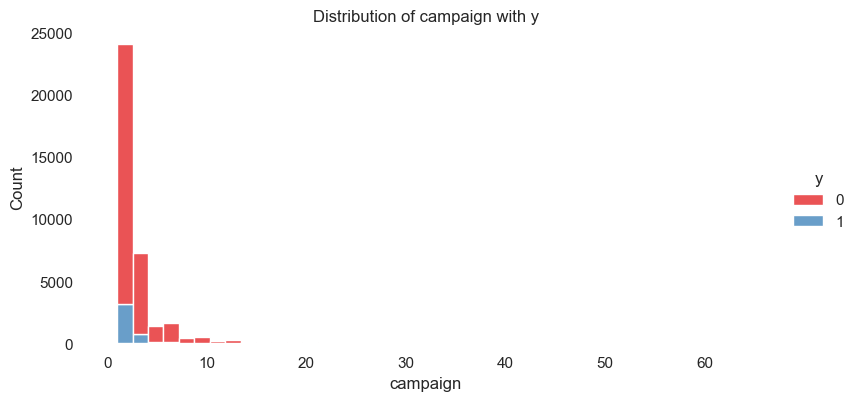

In [ ]:
sns.displot(data=train, kind='hist', x='campaign', hue='y', bins=40,
            multiple='stack', height=4, aspect=2, palette='Set1')
sns.despine(left=True, bottom=True)
plt.title('Distribution of campaign with y');

In [ ]:
# histogram is a bit harder to read
# try discretize campaign to examine its relationship with y
max_campaign = train.campaign.max()
train['campaign_group'] = pd.cut(train.campaign, bins = [0, 1, 2, 3, 5, max_campaign])
campaign_group = train.pivot_table(index='campaign_group', values='y', aggfunc=[np.size, np.mean]).reset_index()
campaign_group.columns = ['campaign_group', 'size', 'proportion of yes']
campaign_group

,campaign_group,size,proportion of yes
0,"(0, 1]",14040,0.144587
1,"(1, 2]",9990,0.112813
2,"(2, 3]",4417,0.113425
3,"(3, 5]",4233,0.089062
4,"(5, 63]",3488,0.056193


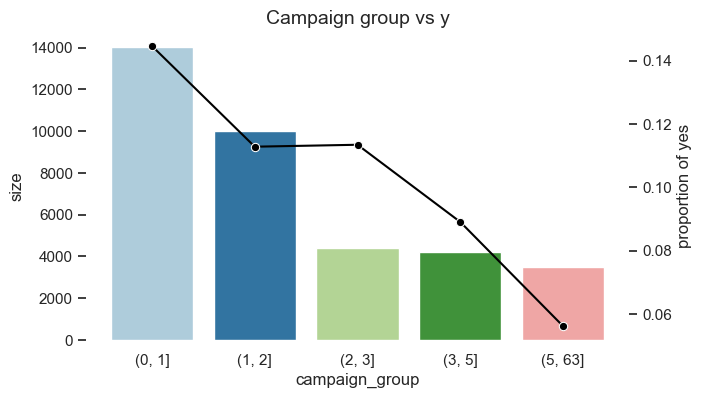

In [ ]:
# visualization of campaign_group
fig, ax1 = plt.subplots(figsize=(7, 4))
sns.barplot(data=campaign_group, x='campaign_group', y='size', ax=ax1)
ax2 = ax1.twinx()
sns.lineplot(data=campaign_group['proportion of yes'], marker='o', color='black', sort = False, ax=ax2)
sns.despine(left=True, bottom=True)
plt.title('Campaign group vs y', fontsize=14);

**Insights**
- As the number of contacts goes up, the proportion of people subscribing is actually dropping. (Clients may get annoyed after multiple contacts)

- *Bussiness suggestion: Invest more on the first 3 contacts, expecially the 1st contact since it appears to have the highest chance of success; moreover, after 5 contacts, there is probably no need to keep pushing because the chance is really slim there.*

### pdays vs y

In [ ]:
# pdays has -1 values and is skewed to the right, try discretization
pdays_max = train.pdays.max()  # 871
train['pdays_group'] = pd.cut(train.pdays, bins = [-1, 0, 30, 120, 180, 210, 390, float('inf')], include_lowest=True, right=False)
pdays_group = train.pivot_table(index='pdays_group', values='y', aggfunc=[np.size, np.mean]).reset_index()
pdays_group.columns = ['pdays_group', 'size', 'proportion of yes']
pdays_group

,pdays_group,size,proportion of yes
0,"[-1.0, 0.0)",29619,0.091563
1,"[0.0, 30.0)",141,0.134752
2,"[30.0, 120.0)",1363,0.402054
3,"[120.0, 180.0)",1015,0.152709
4,"[180.0, 210.0)",1024,0.368164
5,"[210.0, 390.0)",2797,0.113336
6,"[390.0, inf)",209,0.492823


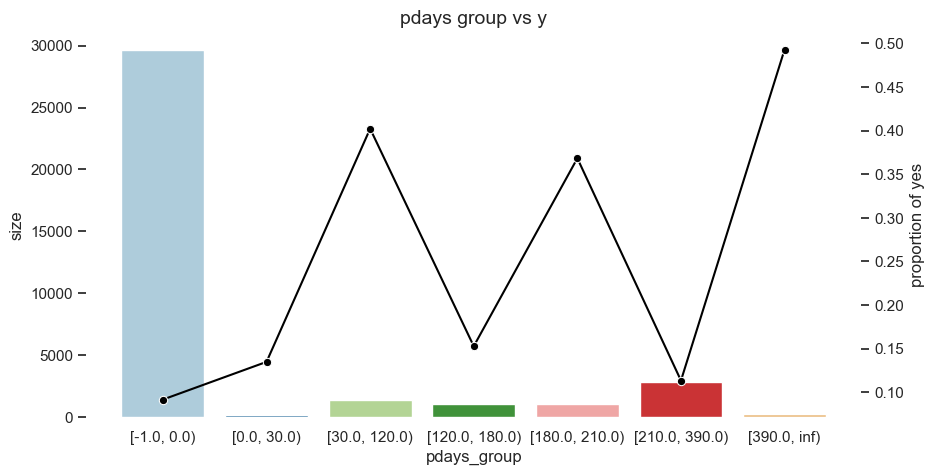

In [ ]:
# visualization of pdays
fig, ax1 = plt.subplots(figsize=(10, 5))
sns.barplot(data=pdays_group, x='pdays_group', y='size', ax=ax1)
ax2 = ax1.twinx()
sns.lineplot(data=pdays_group['proportion of yes'], marker='o', color='black', sort = False, ax=ax2)
sns.despine(left=True, bottom=True)
plt.title('pdays group vs y', fontsize=14);

Some interesting pattern here, maybe this zigzag pattern has something to do with the term of deposits.

Moreover, the proportion of y = 1 is the lowest for clients who have not been previously contacted.

### previous vs y

In [ ]:
# previous is similar to campaign, but for previous contacts
train['previous_group'] = pd.cut(train.previous, bins = [0, 1, 2, 3, 5, float('inf')], include_lowest=True, right=False)
previous_group = train.pivot_table(index='previous_group', values='y', aggfunc=[np.size, np.mean]).reset_index()
previous_group.columns = ['previous_group', 'size', 'proportion of yes']
previous_group

,previous_group,size,proportion of yes
0,"[0.0, 1.0)",29619,0.091563
1,"[1.0, 2.0)",2197,0.213928
2,"[2.0, 3.0)",1671,0.214841
3,"[3.0, 5.0)",1458,0.255830
4,"[5.0, inf)",1223,0.259199


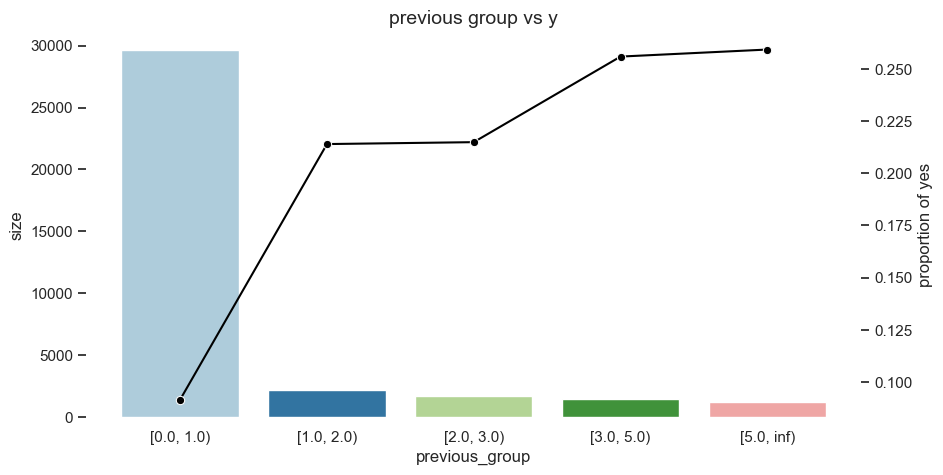

In [ ]:
# visualization of previous contacts
fig, ax1 = plt.subplots(figsize=(10, 5))
sns.barplot(data=previous_group, x='previous_group', y='size', ax=ax1)
ax2 = ax1.twinx()
sns.lineplot(data=previous_group['proportion of yes'], marker='o', color='black', sort = False, ax=ax2)
sns.despine(left=True, bottom=True)
plt.title('previous group vs y', fontsize=14);

Somehow in contrast to the campaign group!

- as number of contacts in current campaign goes up, the proportion goes down.

- as the number of contacts in previous campagn goes up, the proportion actually goes up.

### How does each categorical feature correlate with our target? <a name="3.4"></a>

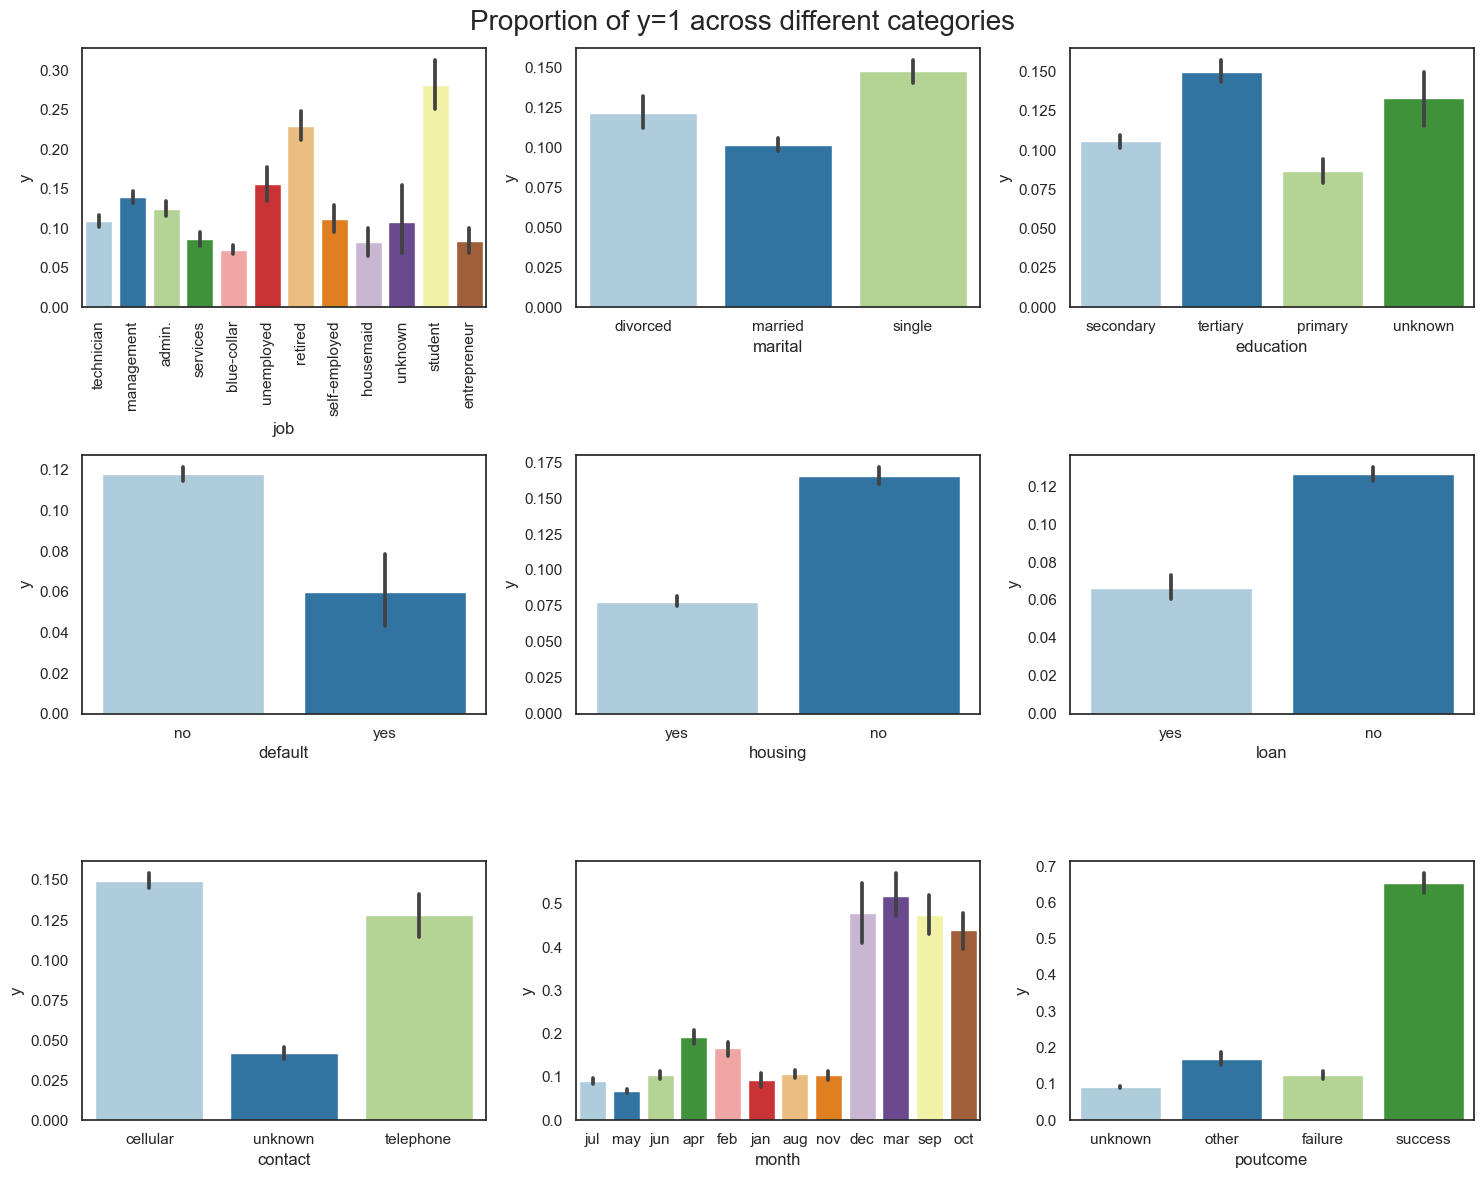

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 12))
for i, ax in enumerate(axes.flat):
    sns.barplot(data=train, x=cat_cols[i], y='y', ax=ax, palette='Paired')
    if cat_cols[i] == 'job':
        ax.tick_params(axis='x', labelrotation=90)
plt.suptitle('Proportion of y=1 across different categories', fontsize=20)
plt.tight_layout()

### Experimenting attribute combinations <a name='3.5'></a>

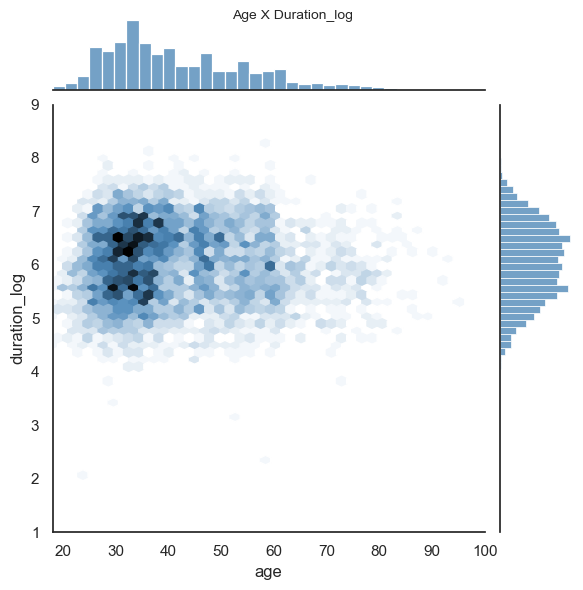

In [ ]:
# age x Duration
sns.jointplot(data=train[train['y'] == 1], x='age', y='duration_log', 
              kind='hex', height=6, xlim=(18, 100), ylim=(1, 9), color='steelblue')
plt.suptitle('Age X Duration_log', fontsize=10);

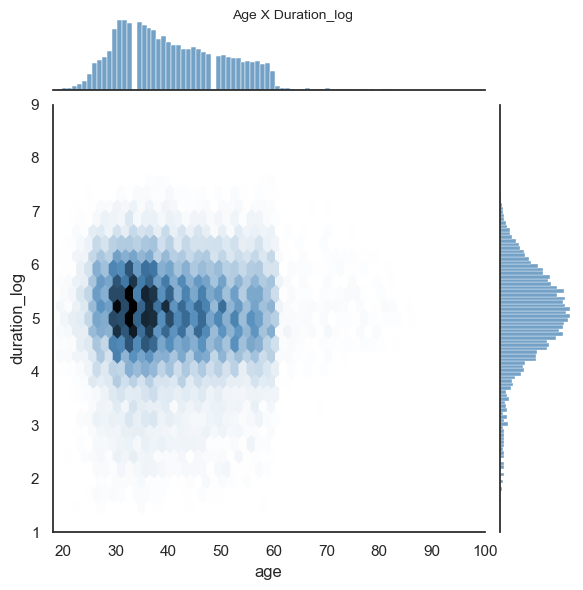

In [ ]:
# age x Duration
sns.jointplot(data=train[train['y'] == 0], x='age', y='duration_log', 
              kind='hex', height=6, xlim=(18, 100), ylim=(1, 9), color='steelblue')
plt.suptitle('Age X Duration_log', fontsize=10);

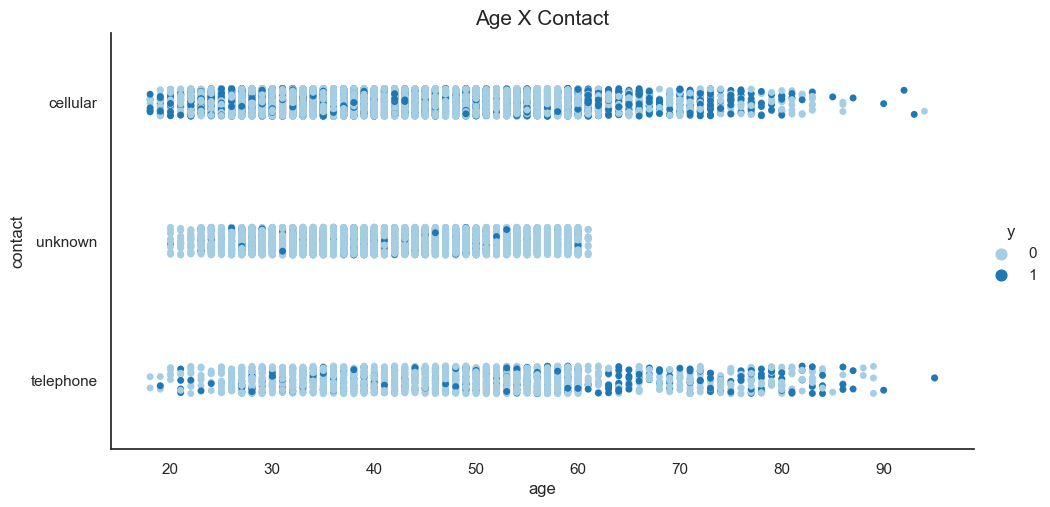

In [ ]:
# Age x Contact
sns.catplot(data=train, x='age', y='contact', hue='y', kind='strip', aspect=2, jitter=True)
plt.title('Age X Contact', fontsize=15);

<a name="4"></a>
# 4 - Preprocessing

In [23]:
# preprocessor and pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [24]:
train.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y', 'balance_log', 'duration_log',
       'campaign_log', 'pdays_log', 'age_group', 'balance_group',
       'campaign_group', 'pdays_group'],
      dtype='object')

In [25]:
train['balance_log'] = np.log(train.balance + 10000)
train['duration_log'] = np.log(train.duration + 0.01)
train['campaign_log'] = np.log(train.campaign + 0.01)
train['pdays_log'] = np.log(train.pdays + 1.01)
min_age = train.age.min()
max_age = train.age.max()
train['age_group'] = pd.cut(train.age, bins=[min_age-1, 30, 35, 40, 45, 50, 55, 60, max_age+1])
train['balance_group'] = pd.cut(train.balance, bins=[float('-inf'), 0, 100, 500, 1500, float('inf')])
max_campaign = train.campaign.max()
train['campaign_group'] = pd.cut(train.campaign, bins = [0, 1, 2, 3, 5, max_campaign])
pdays_max = train.pdays.max()  # 871
train['pdays_group'] = pd.cut(train.pdays, bins = [-1, 0, 30, 120, 180, 210, 390, float('inf')], include_lowest=True, right=False)
train['previous_group'] = pd.cut(train.previous, bins = [0, 1, 2, 3, 5, float('inf')], include_lowest=True, right=False)

In [55]:
test['balance_log'] = np.log(test.balance + 10000)
test['duration_log'] = np.log(test.duration + 0.01)
test['campaign_log'] = np.log(test.campaign + 0.01)
test['pdays_log'] = np.log(test.pdays + 1.01)
min_age = train.age.min()
max_age = train.age.max()
test['age_group'] = pd.cut(test.age, bins=[min_age-1, 30, 35, 40, 45, 50, 55, 60, max_age+1])
test['balance_group'] = pd.cut(test.balance, bins=[float('-inf'), 0, 100, 500, 1500, float('inf')])
max_campaign = train.campaign.max()
test['campaign_group'] = pd.cut(test.campaign, bins = [0, 1, 2, 3, 5, max_campaign])
pdays_max = train.pdays.max()  # 871
test['pdays_group'] = pd.cut(test.pdays, bins = [-1, 0, 30, 120, 180, 210, 390, float('inf')], include_lowest=True, right=False)
test['previous_group'] = pd.cut(test.previous, bins = [0, 1, 2, 3, 5, float('inf')], include_lowest=True, right=False)

In [56]:
cat_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
num_cols = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

In [57]:
cat_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome','age_group', 'balance_group', 'campaign_group', 'pdays_group', 'previous_group']
num_cols = ['duration_log']

In [58]:
X_train = train[cat_cols + num_cols]
y_train = train.y
X_test = test[cat_cols + num_cols]
y_test = test.y

In [59]:
X_train[['age_group','balance_group','campaign_group','pdays_group','previous_group']] = X_train[['age_group','balance_group','campaign_group','pdays_group','previous_group']].astype(str)

In [60]:
X_test[['age_group','balance_group','campaign_group','pdays_group','previous_group']] = X_test[['age_group','balance_group','campaign_group','pdays_group','previous_group']].astype(str)

In [61]:
preprocessor = ColumnTransformer([('cat', OneHotEncoder(drop='if_binary'), cat_cols),
                                  ('num', StandardScaler(), num_cols)])
X_train_prepared = preprocessor.fit_transform(X_train)

In [62]:
X_train_prepared

<36168x72 sparse matrix of type '<class 'numpy.float64'>'
	with 460466 stored elements in Compressed Sparse Row format>

In [63]:
X_test_prepared = preprocessor.transform(X_test)

<a name="5"></a>
# 5 - Modeling

The business goal is to identify who are more likely to subscribe, so that the resources could be more targeted towards the right potentials and not waste on those who will never subscribe. Therefore, the primary metric will be `recall` and `precision` of the positive class, with `F1-score` being the balance of the two. Personally, I think it's a more recall-oriented task where we would sacrifice some precision on the positive class.

In [64]:
# models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

# evaluations
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

# model selection
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

## Baseline models <a name='5.1'></a>

Here just quickly try a few of baseline models with default parameters, also we are using all of the features.

### logistic regression

In [ ]:
lr = LogisticRegression(max_iter=500, class_weight='balanced')
lr_scores = cross_val_score(lr, X_train_prepared, y_train, scoring='f1', cv=5)
lr_scores.mean()

0.5515334229230244

### svm

In [ ]:
svc = SVC(class_weight='balanced')
svc_scores = cross_val_score(svc, X_train_prepared, y_train, scoring='f1', cv=5)
svc_scores.mean()

0.5717865170849074

### adaboost

In [ ]:
ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1, class_weight='balanced'))
ada_scores = cross_val_score(ada, X_train_prepared, y_train, scoring='f1', cv=5)
ada_scores.mean()

0.5573877620728369

### gradient boosting trees

In [ ]:
# equal weights
gbt = GradientBoostingClassifier()
gbt_scores = cross_val_score(gbt, X_train_prepared, y_train, scoring='f1', cv=5)
gbt_scores.mean()

0.5109156876493441

In [ ]:
# tweak sample weights a little bit
sample_weights = np.zeros(len(y_train))
sample_weights[y_train == 1] = 4
sample_weights[y_train == 0] = 1
gbt.fit(X_train_prepared, y_train, sample_weight=sample_weights)
y_test_pred = gbt.predict(X_test_prepared)
print(classification_report(y_test, y_test_pred))
print(confusion_matrix(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.97      0.89      0.93      7985
           1       0.49      0.78      0.60      1058

    accuracy                           0.88      9043
   macro avg       0.73      0.83      0.76      9043
weighted avg       0.91      0.88      0.89      9043

[[7129  856]
 [ 237  821]]


### xgb

In [ ]:
neg_to_pos_ratio = sum(y_train==0) / sum(y_train==1)
neg_to_pos_ratio

7.548333727251241

In [ ]:
xgb = XGBClassifier(eval_metric='logloss', use_label_encoder=False, 
                    scale_pos_weight=neg_to_pos_ratio)
xgb_scores = cross_val_score(xgb, X_train_prepared, y_train, scoring='f1', cv=5)
xgb_scores.mean()

0.6055815185562509

In [ ]:
xgb.fit(X_train_prepared, y_train)
y_test_pred = xgb.predict(X_test_prepared)
print(classification_report(y_test, y_test_pred))
print(confusion_matrix(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.97      0.89      0.93      7985
           1       0.48      0.79      0.60      1058

    accuracy                           0.88      9043
   macro avg       0.73      0.84      0.76      9043
weighted avg       0.91      0.88      0.89      9043

[[7087  898]
 [ 217  841]]


>**Note**: we can actually reach a recall of 0.9 if we keep increasing the weight of positive classes, but the precision will be sufficiently lower than 0.5, therefore decreasing overall f1-score. This tradeoff needs to be considered with bussiness interest and application.

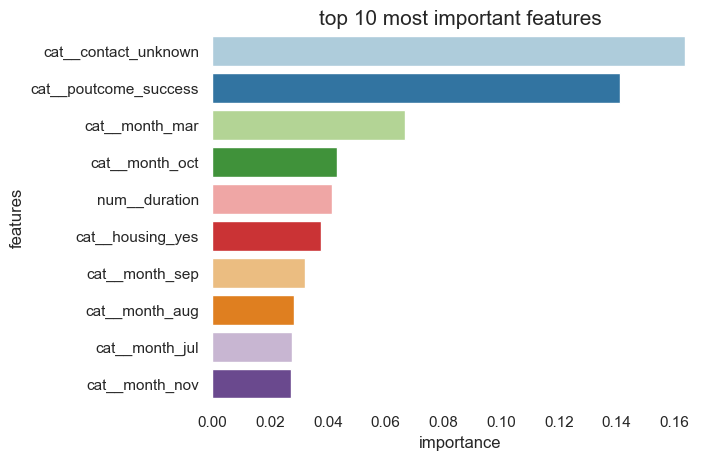

In [ ]:
feature_importance = pd.DataFrame({'features': preprocessor.get_feature_names_out(X_train.columns), 
                                   'importance': xgb.feature_importances_}).sort_values(by='importance', ascending=False)
sns.barplot(data=feature_importance[:10], y='features', x='importance')
sns.despine(left=True, bottom=True)
plt.title('top 10 most important features', fontsize=15);

### neural network

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as tfl
from tensorflow.keras.models import Model

In [ ]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),  # area under the roc curve
      keras.metrics.AUC(name='prc', curve='PR') # area under precision-recall curve
]

def build_model(num_features, metrics=METRICS, output_bias=None):
    # set initial bias to log of the odds
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
        
    inputs = tfl.Input(shape=(num_features,))
    A1 = tfl.Dense(units=16, activation='relu')(inputs)
    A2 = tfl.Dense(units=32, activation='relu')(A1)
    D1 = tfl.Dropout(0.5)(A2)
    outputs = tfl.Dense(units=1, activation='sigmoid', bias_initializer=output_bias)(D1)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
                  loss=keras.losses.BinaryCrossentropy(),
                  metrics=metrics)

    return model

In [ ]:
train_features = X_train_prepared.toarray()
train_labels = np.array(y_train)
test_features = X_test_prepared.toarray()
test_labels = np.array(y_test)

EPOCHS = 100
BATCH_SIZE = 2048  # larger batch size to compensate for imbalanced class
model = build_model(num_features=X_train_prepared.shape[-1],
                    output_bias=np.log(pos/neg))
model.summary()

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 48)]              0         
                                                                 
 dense_26 (Dense)            (None, 16)                784       
                                                                 
 dense_27 (Dense)            (None, 32)                544       
                                                                 
 dropout_13 (Dropout)        (None, 32)                0         
                                                                 
 dense_28 (Dense)            (None, 1)                 33        
                                                                 
Total params: 1,361
Trainable params: 1,361
Non-trainable params: 0
_________________________________________________________________


In [ ]:
baseline_history = model.fit(train_features, train_labels,
                             batch_size=BATCH_SIZE,
                             epochs=EPOCHS,
                             validation_data=(test_features, test_labels))

Epoch 1/100


2022-09-18 18:06:14.652143: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - ETA: 0s - loss: 0.3546 - tp: 0.0000e+00 - fp: 4.0000 - tn: 31933.0000 - fn: 4231.0000 - accuracy: 0.8829 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5980 - prc: 0.1712

2022-09-18 18:06:16.202504: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 3s 75ms/step - loss: 0.3546 - tp: 0.0000e+00 - fp: 4.0000 - tn: 31933.0000 - fn: 4231.0000 - accuracy: 0.8829 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5980 - prc: 0.1712 - val_loss: 0.3379 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 7985.0000 - val_fn: 1058.0000 - val_accuracy: 0.8830 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7589 - val_prc: 0.2798
Epoch 2/100
18/18 [==============================] - 0s 20ms/step - loss: 0.3321 - tp: 20.0000 - fp: 20.0000 - tn: 31917.0000 - fn: 4211.0000 - accuracy: 0.8830 - precision: 0.5000 - recall: 0.0047 - auc: 0.7207 - prc: 0.2733 - val_loss: 0.3143 - val_tp: 3.0000 - val_fp: 6.0000 - val_tn: 7979.0000 - val_fn: 1055.0000 - val_accuracy: 0.8827 - val_precision: 0.3333 - val_recall: 0.0028 - val_auc: 0.8236 - val_prc: 0.3671
Epoch 3/100
18/18 [==============================] - 0s 18ms/step - loss: 0.3091 - tp: 164.0000 - fp: 111.0000 - tn: 31826.0000 - fn: 4067.0

18/18 [==============================] - 0s 16ms/step - loss: 0.2143 - tp: 1534.0000 - fp: 814.0000 - tn: 31123.0000 - fn: 2697.0000 - accuracy: 0.9029 - precision: 0.6533 - recall: 0.3626 - auc: 0.9198 - prc: 0.5811 - val_loss: 0.2142 - val_tp: 401.0000 - val_fp: 219.0000 - val_tn: 7766.0000 - val_fn: 657.0000 - val_accuracy: 0.9031 - val_precision: 0.6468 - val_recall: 0.3790 - val_auc: 0.9191 - val_prc: 0.5731
Epoch 40/100
18/18 [==============================] - 0s 17ms/step - loss: 0.2135 - tp: 1605.0000 - fp: 835.0000 - tn: 31102.0000 - fn: 2626.0000 - accuracy: 0.9043 - precision: 0.6578 - recall: 0.3793 - auc: 0.9201 - prc: 0.5840 - val_loss: 0.2141 - val_tp: 391.0000 - val_fp: 209.0000 - val_tn: 7776.0000 - val_fn: 667.0000 - val_accuracy: 0.9031 - val_precision: 0.6517 - val_recall: 0.3696 - val_auc: 0.9194 - val_prc: 0.5742
Epoch 41/100
18/18 [==============================] - 0s 17ms/step - loss: 0.2117 - tp: 1593.0000 - fp: 894.0000 - tn: 31043.0000 - fn: 2638.0000 - accur

18/18 [==============================] - 0s 19ms/step - loss: 0.2023 - tp: 1789.0000 - fp: 886.0000 - tn: 31051.0000 - fn: 2442.0000 - accuracy: 0.9080 - precision: 0.6688 - recall: 0.4228 - auc: 0.9294 - prc: 0.6194 - val_loss: 0.2070 - val_tp: 415.0000 - val_fp: 239.0000 - val_tn: 7746.0000 - val_fn: 643.0000 - val_accuracy: 0.9025 - val_precision: 0.6346 - val_recall: 0.3922 - val_auc: 0.9250 - val_prc: 0.5968
Epoch 78/100
18/18 [==============================] - 0s 17ms/step - loss: 0.2024 - tp: 1686.0000 - fp: 858.0000 - tn: 31079.0000 - fn: 2545.0000 - accuracy: 0.9059 - precision: 0.6627 - recall: 0.3985 - auc: 0.9298 - prc: 0.6150 - val_loss: 0.2069 - val_tp: 422.0000 - val_fp: 253.0000 - val_tn: 7732.0000 - val_fn: 636.0000 - val_accuracy: 0.9017 - val_precision: 0.6252 - val_recall: 0.3989 - val_auc: 0.9253 - val_prc: 0.5966
Epoch 79/100
18/18 [==============================] - 0s 17ms/step - loss: 0.2010 - tp: 1765.0000 - fp: 852.0000 - tn: 31085.0000 - fn: 2466.0000 - accur

In [ ]:
def plot_loss(history, label, n):
    plt.plot(history.epoch, 
             history.history['loss'],
             color=colors[n], 
             label='Train ' + label)
    plt.plot(history.epoch, 
             history.history['val_loss'],
             color=colors[n], 
             label='Test ' + label,
             linestyle='--')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

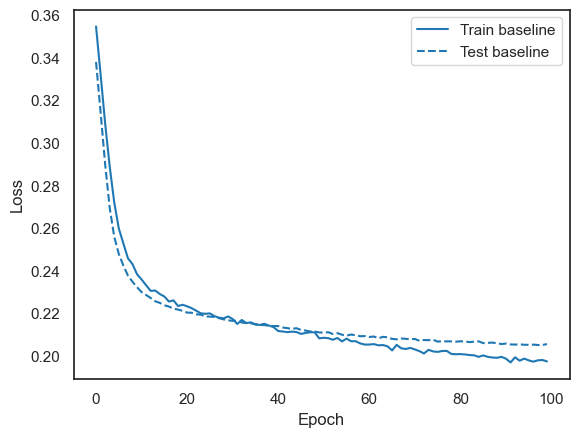

In [ ]:
plot_loss(baseline_history, 'baseline', 1)

In [ ]:
def plot_metrics(history):
    plt.figure(dpi=200, figsize=(12, 10))
    metrics = ['accuracy', 'precision', 'recall', 'prc']
    for i, metric in enumerate(metrics):
        plt.subplot(2, 2, i+1)
        plt.plot(history.epoch, 
                 history.history[metric], 
                 color=colors[1],
                 label='Train')
        plt.plot(history.epoch, 
                 history.history['val_' + metric], 
                 color=colors[1],
                 label='Test',
                 linestyle='--')
        plt.xlabel('Epoch')
        plt.ylabel(metric.capitalize())
        plt.legend()
    plt.tight_layout(pad=1.5)

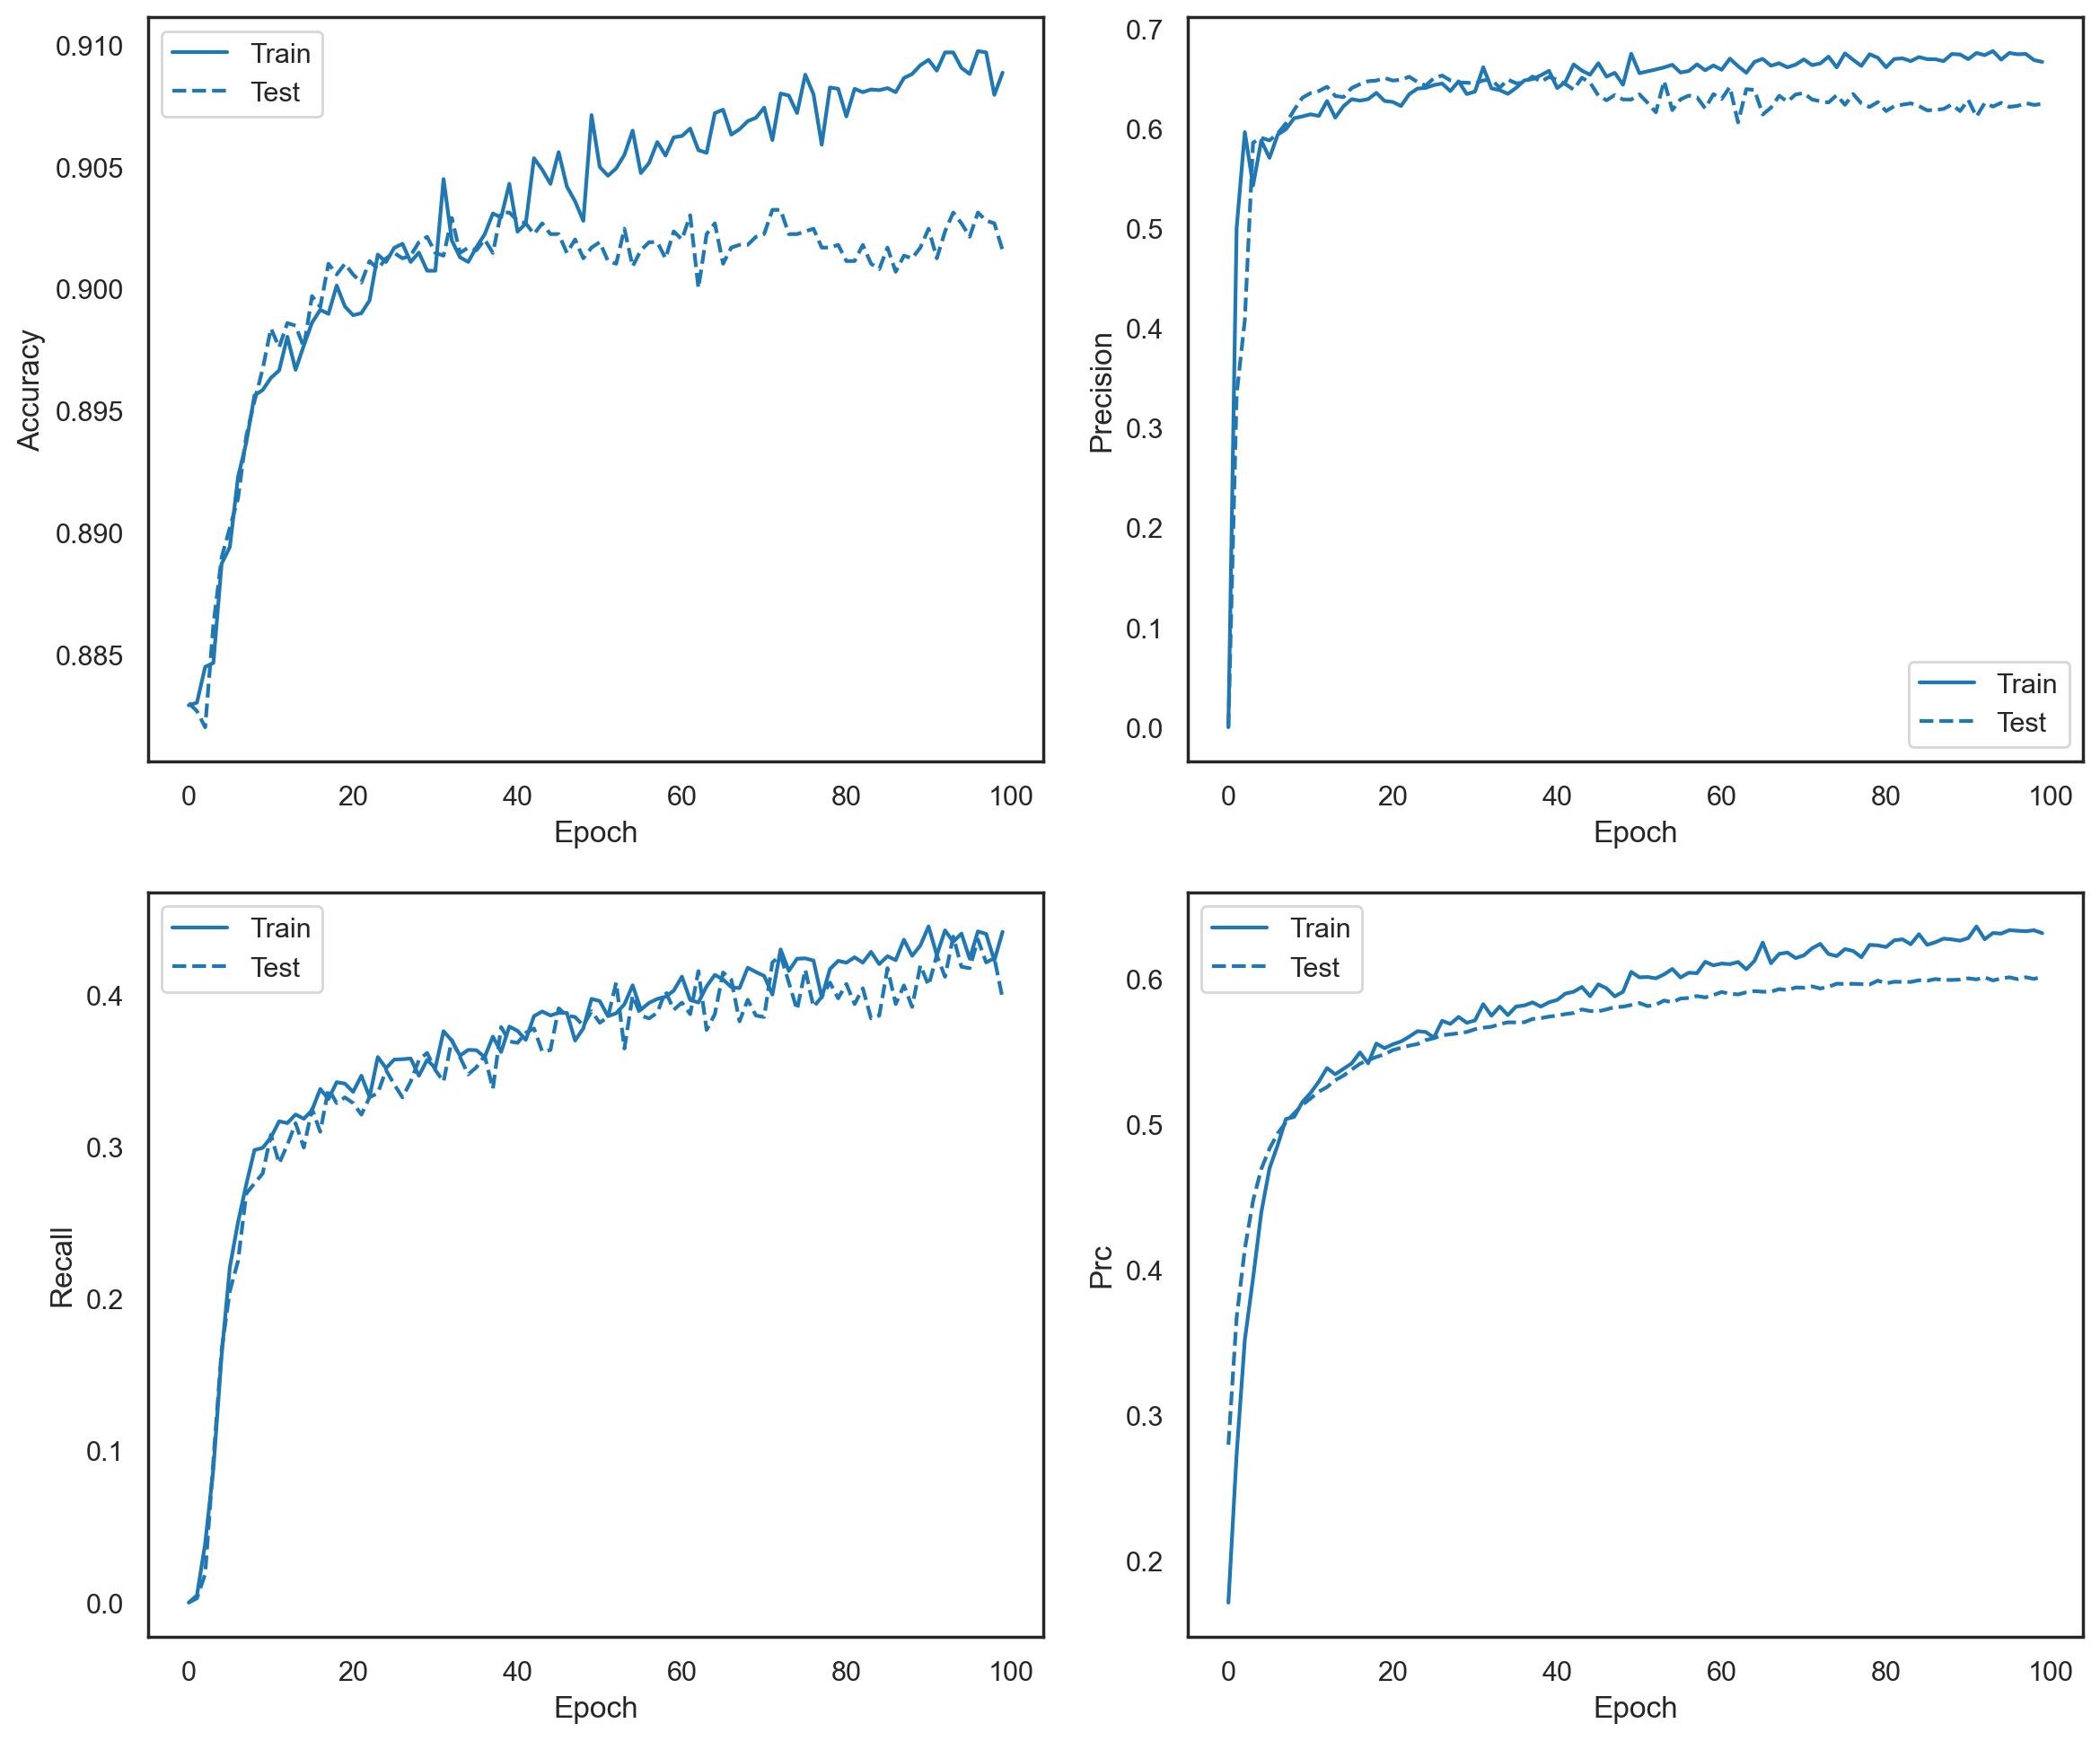

In [ ]:
plot_metrics(baseline_history)

In [ ]:
p = baseline_history.history['val_precision'][-1]
r = baseline_history.history['val_recall'][-1]
f1 = 2 * p * r / (p + r)
acc = baseline_history.history['val_accuracy'][-1]
baseline_result = f'baseline nn: precision={p:.2f}, recall={r:.2f}, f1={f1:.2f}, accuracy={acc:.2f}'
print(baseline_result)

baseline nn: precision=0.62, recall=0.40, f1=0.49, accuracy=0.90


## Hyperparameter tuning <a name='5.2'></a>

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

### svm

In [ ]:
param_grid = {'kernel': ['rbf'],
              'gamma': ['scale', 0.01, 0.1, 1],
              'C': [0.1, 0.5, 1]}
svm_gs = GridSearchCV(estimator=SVC(class_weight='balanced'),
                      param_grid=param_grid, scoring='f1', cv=3)
svm_gs.fit(X_train_prepared, y_train)

GridSearchCV(cv=3, estimator=SVC(class_weight='balanced'),
             param_grid={'C': [0.1, 0.3, 0.5, 1],
                         'gamma': ['scale', 0.01, 0.1, 1], 'kernel': ['rbf']},
             scoring='f1')

In [ ]:
svm_gs.best_params_

{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}

In [ ]:
y_test_pred = svm_gs.predict(X_test_prepared)
print(classification_report(y_test, y_test_pred))
print(confusion_matrix(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.98      0.85      0.91      7985
           1       0.43      0.86      0.58      1058

    accuracy                           0.85      9043
   macro avg       0.71      0.86      0.74      9043
weighted avg       0.92      0.85      0.87      9043

[[6790 1195]
 [ 145  913]]


### adaboost

In [ ]:
param_grid = {'n_estimators': [50, 100, 200, 300, 400], 
              'learning_rate': np.logspace(-2, 0, num=10),
              'base_estimator__max_features': ['sqrt', 'log2', None]}
ada_gs = GridSearchCV(AdaBoostClassifier(DecisionTreeClassifier(max_depth=1, class_weight='balanced')),
                      param_grid=param_grid, scoring='f1', n_jobs=-1, cv=3)
ada_gs.fit(X_train_prepared, y_train)

GridSearchCV(cv=3,
             estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(class_weight='balanced',
                                                                                max_depth=1)),
             n_jobs=-1,
             param_grid={'base_estimator__max_features': ['sqrt', 'log2', None],
                         'learning_rate': array([0.01      , 0.01668101, 0.02782559, 0.04641589, 0.07742637,
       0.12915497, 0.21544347, 0.35938137, 0.59948425, 1.        ]),
                         'n_estimators': [50, 100, 200, 300, 400]},
             scoring='f1')

In [ ]:
ada_gs.best_params_

{'base_estimator__max_features': 'log2',
 'learning_rate': 0.21544346900318834,
 'n_estimators': 400}

In [ ]:
y_test_pred = ada_gs.predict(X_test_prepared)
print(classification_report(y_test, y_test_pred))
print(confusion_matrix(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.97      0.85      0.91      7985
           1       0.42      0.83      0.56      1058

    accuracy                           0.85      9043
   macro avg       0.70      0.84      0.73      9043
weighted avg       0.91      0.85      0.87      9043

[[6784 1201]
 [ 180  878]]


### xgboost

In [65]:
# randomized search
param_grid = {'n_estimators': [100, 200, 300, 400], 
              'max_leaves': [8, 12, 16, 20, 24, 28, 32],
              'learning_rate': np.logspace(-2, -1, num=10),
              'scale_pos_weight': [4],
              'gamma': np.logspace(-2, -1, 10),
              'min_child_weight': np.logspace(-2, -1, num=10),
              'lambda': [0.1, 0.3, 0.5, 1]}
xgb_gs = RandomizedSearchCV(estimator=XGBClassifier(eval_metric='logloss', use_label_encoder=False),
                            param_distributions=param_grid,
                            scoring='f1', cv=3, n_iter=10)
xgb_gs.fit(X_train_prepared, y_train);

In [66]:
xgb_gs.best_params_

{'scale_pos_weight': 4,
 'n_estimators': 300,
 'min_child_weight': 0.046415888336127774,
 'max_leaves': 12,
 'learning_rate': 0.046415888336127774,
 'lambda': 0.5,
 'gamma': 0.016681005372000592}

In [67]:
y_test_pred = xgb_gs.predict(X_test_prepared)
print(classification_report(y_test, y_test_pred))
print(confusion_matrix(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.97      0.90      0.93      7985
           1       0.49      0.76      0.60      1058

    accuracy                           0.88      9043
   macro avg       0.73      0.83      0.76      9043
weighted avg       0.91      0.88      0.89      9043

[[7154  831]
 [ 252  806]]


In [68]:
# finer search
param_grid = {'n_estimators': [300], 
              'max_leaves': [16, 20, 24],
              'learning_rate': [0.03, 0.05, 0.07],
              'scale_pos_weight': [4],
              'gamma': [0.05, 0.06, 0.07],
              'min_child_weight': [0.05, 0.07, 0.1],
              'lambda': [0.1, 0.5, 1]}
xgb_gs = GridSearchCV(estimator=XGBClassifier(eval_metric='logloss', use_label_encoder=False),
                     param_grid=param_grid, scoring='f1', cv=3)
xgb_gs.fit(X_train_prepared, y_train)

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     m...
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, pre

In [69]:
y_test_pred = xgb_gs.predict(X_test_prepared)
print(classification_report(y_test, y_test_pred))
print(confusion_matrix(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.97      0.90      0.93      7985
           1       0.49      0.77      0.60      1058

    accuracy                           0.88      9043
   macro avg       0.73      0.83      0.77      9043
weighted avg       0.91      0.88      0.89      9043

[[7151  834]
 [ 245  813]]


### LGBM

In [70]:
cat_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome','age_group', 'balance_group', 'campaign_group', 'pdays_group', 'previous_group']
num_cols = ['duration_log']

In [77]:
from sklearn import preprocessing

def getencoded(X):
    encoded_features = []
    for feature in cat_cols:
        encoded_feat = preprocessing.OneHotEncoder().fit_transform(X[feature].values.reshape(-1,1)).toarray()
        n = X[feature].nunique()
        cols = ['{}_{}'.format(feature,n) for n in range(1, n+1)]
        encoded_df = pd.DataFrame(encoded_feat, columns = cols)
        encoded_df.index = X.index
        encoded_features.append(encoded_df)
    return encoded_features

In [81]:
drop_cols = ['job','marital','default','housing','contact','loan','month','poutcome','age_group','balance_group','campaign_group','pdays_group','previous_group']

In [82]:
X_train = train[cat_cols + num_cols]
y_train = train['y']

X_test = test[cat_cols + num_cols]
y_test = test['y']

for feature in cat_cols:
    x_le = preprocessing.LabelEncoder()
    X_train[feature]= x_le.fit_transform(X_train[feature])
    X_test[feature] = x_le.transform(X_test[feature])

encoded_features_train = getencoded(X_train)
encoded_features_test = getencoded(X_test)

X_train = pd.concat([X_train, *encoded_features_train],axis =1)
X_test = pd.concat([X_test, *encoded_features_test],axis =1)

x1_scale = StandardScaler()
X_train_prepared = x1_scale.fit_transform(X_train.drop(columns = drop_cols)) 
X_test_prepared = x1_scale.transform(X_test.drop(columns = drop_cols)) 


In [83]:
from sklearn import metrics as met


def custom_loss_func(y_actual, y_pred):
    cm = met.confusion_matrix(y_actual, y_pred).ravel().tolist()
    precision = (cm[3])/(cm[3]+cm[1])
    recall = (cm[3])/(cm[3]+cm[2])
    f1score = 2*(precision*recall/(precision+recall))
    return f1score


custom_scorer = met.make_scorer(custom_loss_func, greater_is_better=True)

In [103]:
import lightgbm as lgb
params = {
    'application': 'binary', # for binary classification
    #'num_class' : 3, # used for multi-classes
    'boosting_type': 'gbdt', # traditional gradient boosting decision tree
    'num_iterations': 300, # number of times of boosting
    'learning_rate': 0.05,
    'num_leaves': 62,
    'max_depth': -1, # <0 means no limit
    'max_bin': 510, # Small number of bins may reduce training accuracy but can deal with over-fitting
    'lambda_l1': 5, # L1 regularization
    'lambda_l2': 10, # L2 regularization
    'subsample_for_bin': 2000, # number of samples for constructing bins
    'subsample': 1, # subsample ratio of the training instance
    'colsample_bytree': 0.8, # subsample ratio of columns when constructing the tree
    'min_split_gain': 0.5, # minimum loss reduction required to make further partition on a leaf node of the tree
    'min_child_weight': 1, # minimum sum of instance weight (hessian) needed in a leaf
    'min_child_samples': 5, # minimum number of data needed in a leaf
    'scale_pos_weight': 99
}
gridParams = {
    'learning_rate': [0.01],
    'n_estimators': [16,18,20],
    'num_leaves': [16,20,24], # large num_leaves helps improve accuracy but might lead to over-fitting
    'num_iterations': [1000],
    'boosting_type' : ['gbdt'], # for better accuracy -> try dart
    'max_bin':[255], # large max_bin helps improve accuracy but might slow down training progress
    'colsample_bytree' : [0.64],
    'subsample' : [0.7],
    'reg_alpha' : [0.6],
    'reg_lambda' : [3],
    'max_depth' : [6],
    'scale_pos_weight': [3],
    'min_child_weight': [0.01],
    'min_child_samples': [25]
    }

mdl = lgb.LGBMClassifier(boosting_type= 'gbdt', 
          objective = 'binary', 
          n_jobs = 5, 
          subsample_for_bin = params['subsample_for_bin'],
          min_split_gain = params['min_split_gain'],) 



grid = GridSearchCV(mdl, gridParams, verbose=1, cv=4, n_jobs=-1, scoring=custom_scorer)
# Run the grid
grid.fit(X_train_prepared, y_train)


print(grid.best_params_)
print(grid.best_score_)


params['colsample_bytree'] = grid.best_params_['colsample_bytree']
params['learning_rate'] = grid.best_params_['learning_rate'] 
params['max_bin'] = grid.best_params_['max_bin']
params['num_leaves'] = grid.best_params_['num_leaves']
params['reg_alpha'] = grid.best_params_['reg_alpha']
params['reg_lambda'] = grid.best_params_['reg_lambda']
params['subsample'] = grid.best_params_['subsample']
params['max_depth'] = grid.best_params_['max_depth']
params['n_estimators'] = grid.best_params_['n_estimators']
params['scale_pos_weight'] = grid.best_params_['scale_pos_weight']
params['num_iterations'] = grid.best_params_['num_iterations']
params['min_child_weight'] = grid.best_params_['min_child_weight']
params['min_child_samples'] = grid.best_params_['min_child_samples']

Fitting 4 folds for each of 9 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  36 | elapsed:   21.1s remaining:   54.9s
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:   26.3s finished


{'boosting_type': 'gbdt', 'colsample_bytree': 0.64, 'learning_rate': 0.01, 'max_bin': 255, 'max_depth': 6, 'min_child_samples': 25, 'min_child_weight': 0.01, 'n_estimators': 16, 'num_iterations': 1000, 'num_leaves': 20, 'reg_alpha': 0.6, 'reg_lambda': 3, 'scale_pos_weight': 3, 'subsample': 0.7}
0.6159391502465821


In [104]:
final_mdl = lgb.LGBMClassifier(**params, 
          objective = 'binary',   
          n_jobs = 5, 
          verbose = -1,
         )

final_mdl.fit(X_train_prepared, y_train)

LGBMClassifier(application='binary', colsample_bytree=0.64, lambda_l1=5,
               lambda_l2=10, learning_rate=0.01, max_bin=255, max_depth=6,
               min_child_samples=25, min_child_weight=0.01, min_split_gain=0.5,
               n_estimators=16, n_jobs=5, num_iterations=1000, num_leaves=20,
               objective='binary', reg_alpha=0.6, reg_lambda=3,
               scale_pos_weight=3, subsample=0.7, subsample_for_bin=2000,
               verbose=-1)

In [105]:
y_test_pred = final_mdl.predict(X_test_prepared)

print(classification_report(y_test, y_test_pred))
print(confusion_matrix(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.96      0.91      0.94      7985
           1       0.52      0.75      0.61      1058

    accuracy                           0.89      9043
   macro avg       0.74      0.83      0.77      9043
weighted avg       0.91      0.89      0.90      9043

[[7250  735]
 [ 266  792]]


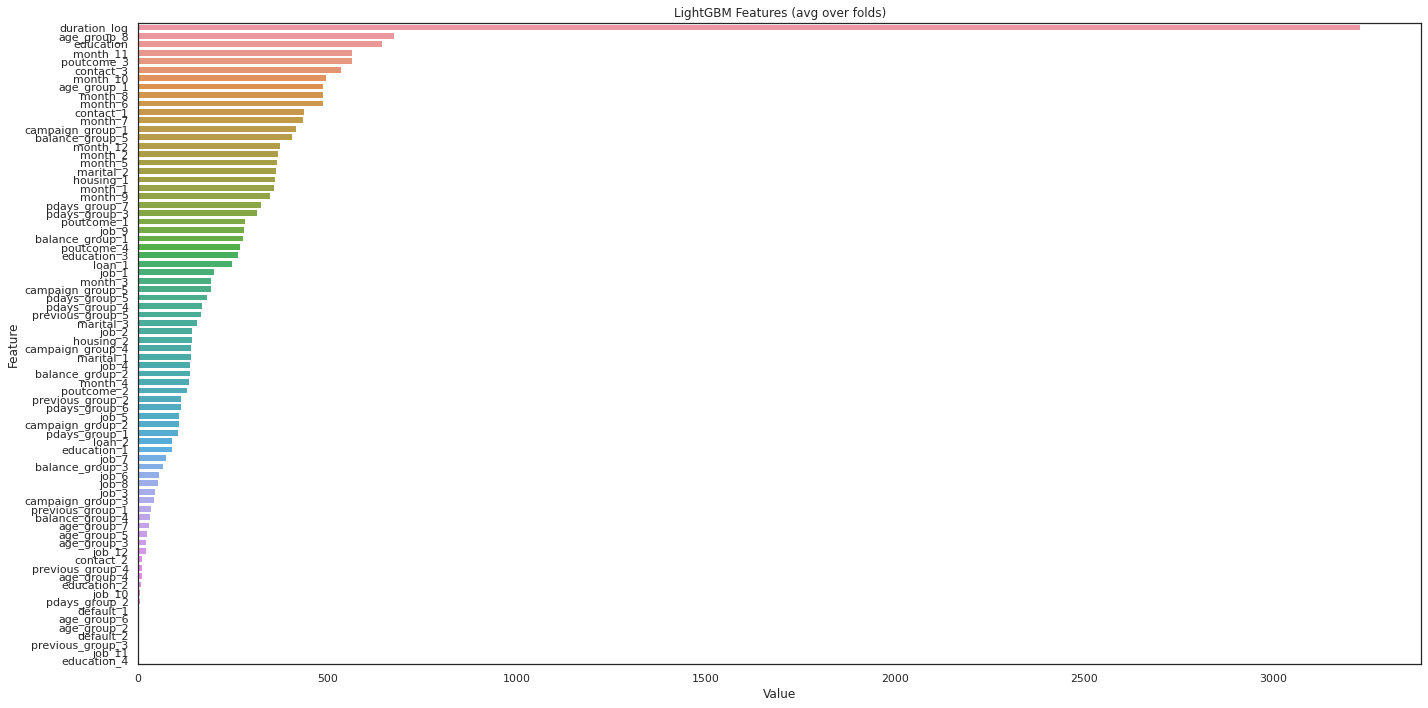

<Figure size 432x288 with 0 Axes>

In [106]:
feature_imp = pd.DataFrame(sorted(zip(final_mdl.feature_importances_,X_train.drop(columns = drop_cols).columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()
plt.savefig('lgbm_importances-01.png')

### emsemble

In [ ]:
svm = SVC(C=1, 
          gamma=0.1, 
          kernel='rbf', 
          class_weight='balanced')

ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(class_weight='balanced', max_features='log2'), 
                         n_estimators=400, 
                         learning_rate=0.2)

xgb = XGBClassifier(eval_metric='logloss', 
                    use_label_encoder=False, 
                    scale_pos_weight=4,
                    n_estimators=300,
                    min_child_weight=0.01,
                    max_leaves=28,
                    learning_rate=0.03,
                    reg_lambda=1,
                    gamma=0.07)

combined = VotingClassifier(estimators=[('svm', svm), ('adaboost', ada), ('xgboost', xgb)], voting='hard')
cv_result = cross_val_score(combined, X_train_prepared, y_train, scoring='f1', cv=5)
print('cv f1:', cv_result.mean())

combined.fit(X_train_prepared, y_train)
y_test_pred = combined.predict(X_test_prepared)
print(classification_report(y_test, y_test_pred))
print(confusion_matrix(y_test, y_test_pred))

cv f1: 0.616729200865213
              precision    recall  f1-score   support

           0       0.97      0.89      0.93      7985
           1       0.50      0.81      0.62      1058

    accuracy                           0.88      9043
   macro avg       0.74      0.85      0.77      9043
weighted avg       0.92      0.88      0.89      9043

[[7130  855]
 [ 205  853]]


### neural network

First, try tweak class weights to make the model pay more attention to the positive class.

In [ ]:
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))
print('Total weights: {:.0f}'.format(pos * weight_for_1 + neg * weight_for_0))
print('Total samples: {:.0f}'.format(total))
# note that after tweaking, the sum of weights remains the same

Weight for class 0: 0.57
Weight for class 1: 4.27
Total weights: 36168
Total samples: 36168


In [ ]:
weighted_model = build_model(num_features=train_features.shape[-1],
                             output_bias=np.log(pos/neg))
weighted_model.summary()

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 48)]              0         
                                                                 
 dense_29 (Dense)            (None, 16)                784       
                                                                 
 dense_30 (Dense)            (None, 32)                544       
                                                                 
 dropout_14 (Dropout)        (None, 32)                0         
                                                                 
 dense_31 (Dense)            (None, 1)                 33        
                                                                 
Total params: 1,361
Trainable params: 1,361
Non-trainable params: 0
_________________________________________________________________


In [ ]:
weighted_history = weighted_model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(test_features, test_labels),
    class_weight=class_weight)

Epoch 1/100


2022-09-18 18:08:08.931508: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - ETA: 0s - loss: 1.0869 - tp: 426.0000 - fp: 262.0000 - tn: 39660.0000 - fn: 4863.0000 - accuracy: 0.8866 - precision: 0.6192 - recall: 0.0805 - auc: 0.6675 - prc: 0.2712

2022-09-18 18:08:11.333912: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 3s 140ms/step - loss: 1.0869 - tp: 426.0000 - fp: 262.0000 - tn: 39660.0000 - fn: 4863.0000 - accuracy: 0.8866 - precision: 0.6192 - recall: 0.0805 - auc: 0.6675 - prc: 0.2712 - val_loss: 0.3574 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 7985.0000 - val_fn: 1058.0000 - val_accuracy: 0.8830 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6559 - val_prc: 0.1978
Epoch 2/100
18/18 [==============================] - 0s 20ms/step - loss: 0.8802 - tp: 163.0000 - fp: 329.0000 - tn: 31608.0000 - fn: 4068.0000 - accuracy: 0.8784 - precision: 0.3313 - recall: 0.0385 - auc: 0.5948 - prc: 0.1722 - val_loss: 0.4013 - val_tp: 44.0000 - val_fp: 54.0000 - val_tn: 7931.0000 - val_fn: 1014.0000 - val_accuracy: 0.8819 - val_precision: 0.4490 - val_recall: 0.0416 - val_auc: 0.6880 - val_prc: 0.2399
Epoch 3/100
18/18 [==============================] - 0s 20ms/step - loss: 0.7200 - tp: 1088.0000 - fp: 3433.0000 - tn: 28504.0000 - fn: 3143.00

18/18 [==============================] - 0s 18ms/step - loss: 0.4022 - tp: 3497.0000 - fp: 5229.0000 - tn: 26708.0000 - fn: 734.0000 - accuracy: 0.8351 - precision: 0.4008 - recall: 0.8265 - auc: 0.9043 - prc: 0.5199 - val_loss: 0.4032 - val_tp: 889.0000 - val_fp: 1358.0000 - val_tn: 6627.0000 - val_fn: 169.0000 - val_accuracy: 0.8311 - val_precision: 0.3956 - val_recall: 0.8403 - val_auc: 0.9099 - val_prc: 0.5242
Epoch 21/100
18/18 [==============================] - 0s 16ms/step - loss: 0.4009 - tp: 3477.0000 - fp: 5255.0000 - tn: 26682.0000 - fn: 754.0000 - accuracy: 0.8339 - precision: 0.3982 - recall: 0.8218 - auc: 0.9046 - prc: 0.5192 - val_loss: 0.3954 - val_tp: 886.0000 - val_fp: 1343.0000 - val_tn: 6642.0000 - val_fn: 172.0000 - val_accuracy: 0.8325 - val_precision: 0.3975 - val_recall: 0.8374 - val_auc: 0.9102 - val_prc: 0.5255
Epoch 22/100
18/18 [==============================] - 0s 17ms/step - loss: 0.3988 - tp: 3471.0000 - fp: 5111.0000 - tn: 26826.0000 - fn: 760.0000 - acc

18/18 [==============================] - 0s 17ms/step - loss: 0.3588 - tp: 3622.0000 - fp: 5273.0000 - tn: 26664.0000 - fn: 609.0000 - accuracy: 0.8374 - precision: 0.4072 - recall: 0.8561 - auc: 0.9185 - prc: 0.5576 - val_loss: 0.3692 - val_tp: 925.0000 - val_fp: 1387.0000 - val_tn: 6598.0000 - val_fn: 133.0000 - val_accuracy: 0.8319 - val_precision: 0.4001 - val_recall: 0.8743 - val_auc: 0.9205 - val_prc: 0.5597
Epoch 59/100
18/18 [==============================] - 0s 17ms/step - loss: 0.3590 - tp: 3608.0000 - fp: 5220.0000 - tn: 26717.0000 - fn: 623.0000 - accuracy: 0.8384 - precision: 0.4087 - recall: 0.8528 - auc: 0.9189 - prc: 0.5642 - val_loss: 0.3644 - val_tp: 925.0000 - val_fp: 1368.0000 - val_tn: 6617.0000 - val_fn: 133.0000 - val_accuracy: 0.8340 - val_precision: 0.4034 - val_recall: 0.8743 - val_auc: 0.9207 - val_prc: 0.5599
Epoch 60/100
18/18 [==============================] - 0s 17ms/step - loss: 0.3590 - tp: 3636.0000 - fp: 5295.0000 - tn: 26642.0000 - fn: 595.0000 - acc

18/18 [==============================] - 0s 17ms/step - loss: 0.3317 - tp: 3714.0000 - fp: 5037.0000 - tn: 26900.0000 - fn: 517.0000 - accuracy: 0.8464 - precision: 0.4244 - recall: 0.8778 - auc: 0.9292 - prc: 0.5925 - val_loss: 0.3439 - val_tp: 934.0000 - val_fp: 1293.0000 - val_tn: 6692.0000 - val_fn: 124.0000 - val_accuracy: 0.8433 - val_precision: 0.4194 - val_recall: 0.8828 - val_auc: 0.9264 - val_prc: 0.5750
Epoch 97/100
18/18 [==============================] - 0s 16ms/step - loss: 0.3338 - tp: 3719.0000 - fp: 5056.0000 - tn: 26881.0000 - fn: 512.0000 - accuracy: 0.8461 - precision: 0.4238 - recall: 0.8790 - auc: 0.9280 - prc: 0.5841 - val_loss: 0.3309 - val_tp: 924.0000 - val_fp: 1229.0000 - val_tn: 6756.0000 - val_fn: 134.0000 - val_accuracy: 0.8493 - val_precision: 0.4292 - val_recall: 0.8733 - val_auc: 0.9266 - val_prc: 0.5783
Epoch 98/100
18/18 [==============================] - 0s 16ms/step - loss: 0.3309 - tp: 3726.0000 - fp: 5036.0000 - tn: 26901.0000 - fn: 505.0000 - acc

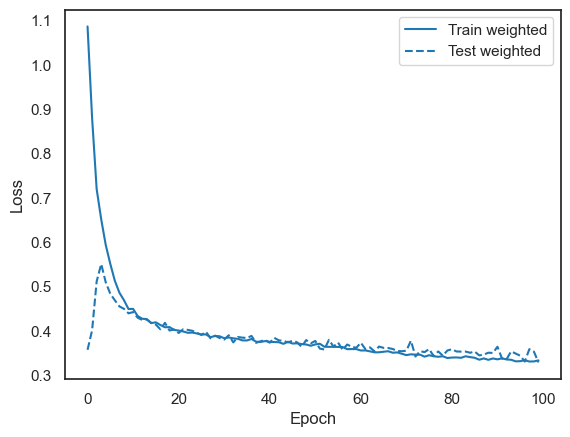

In [ ]:
plot_loss(weighted_history, 'weighted', 1)

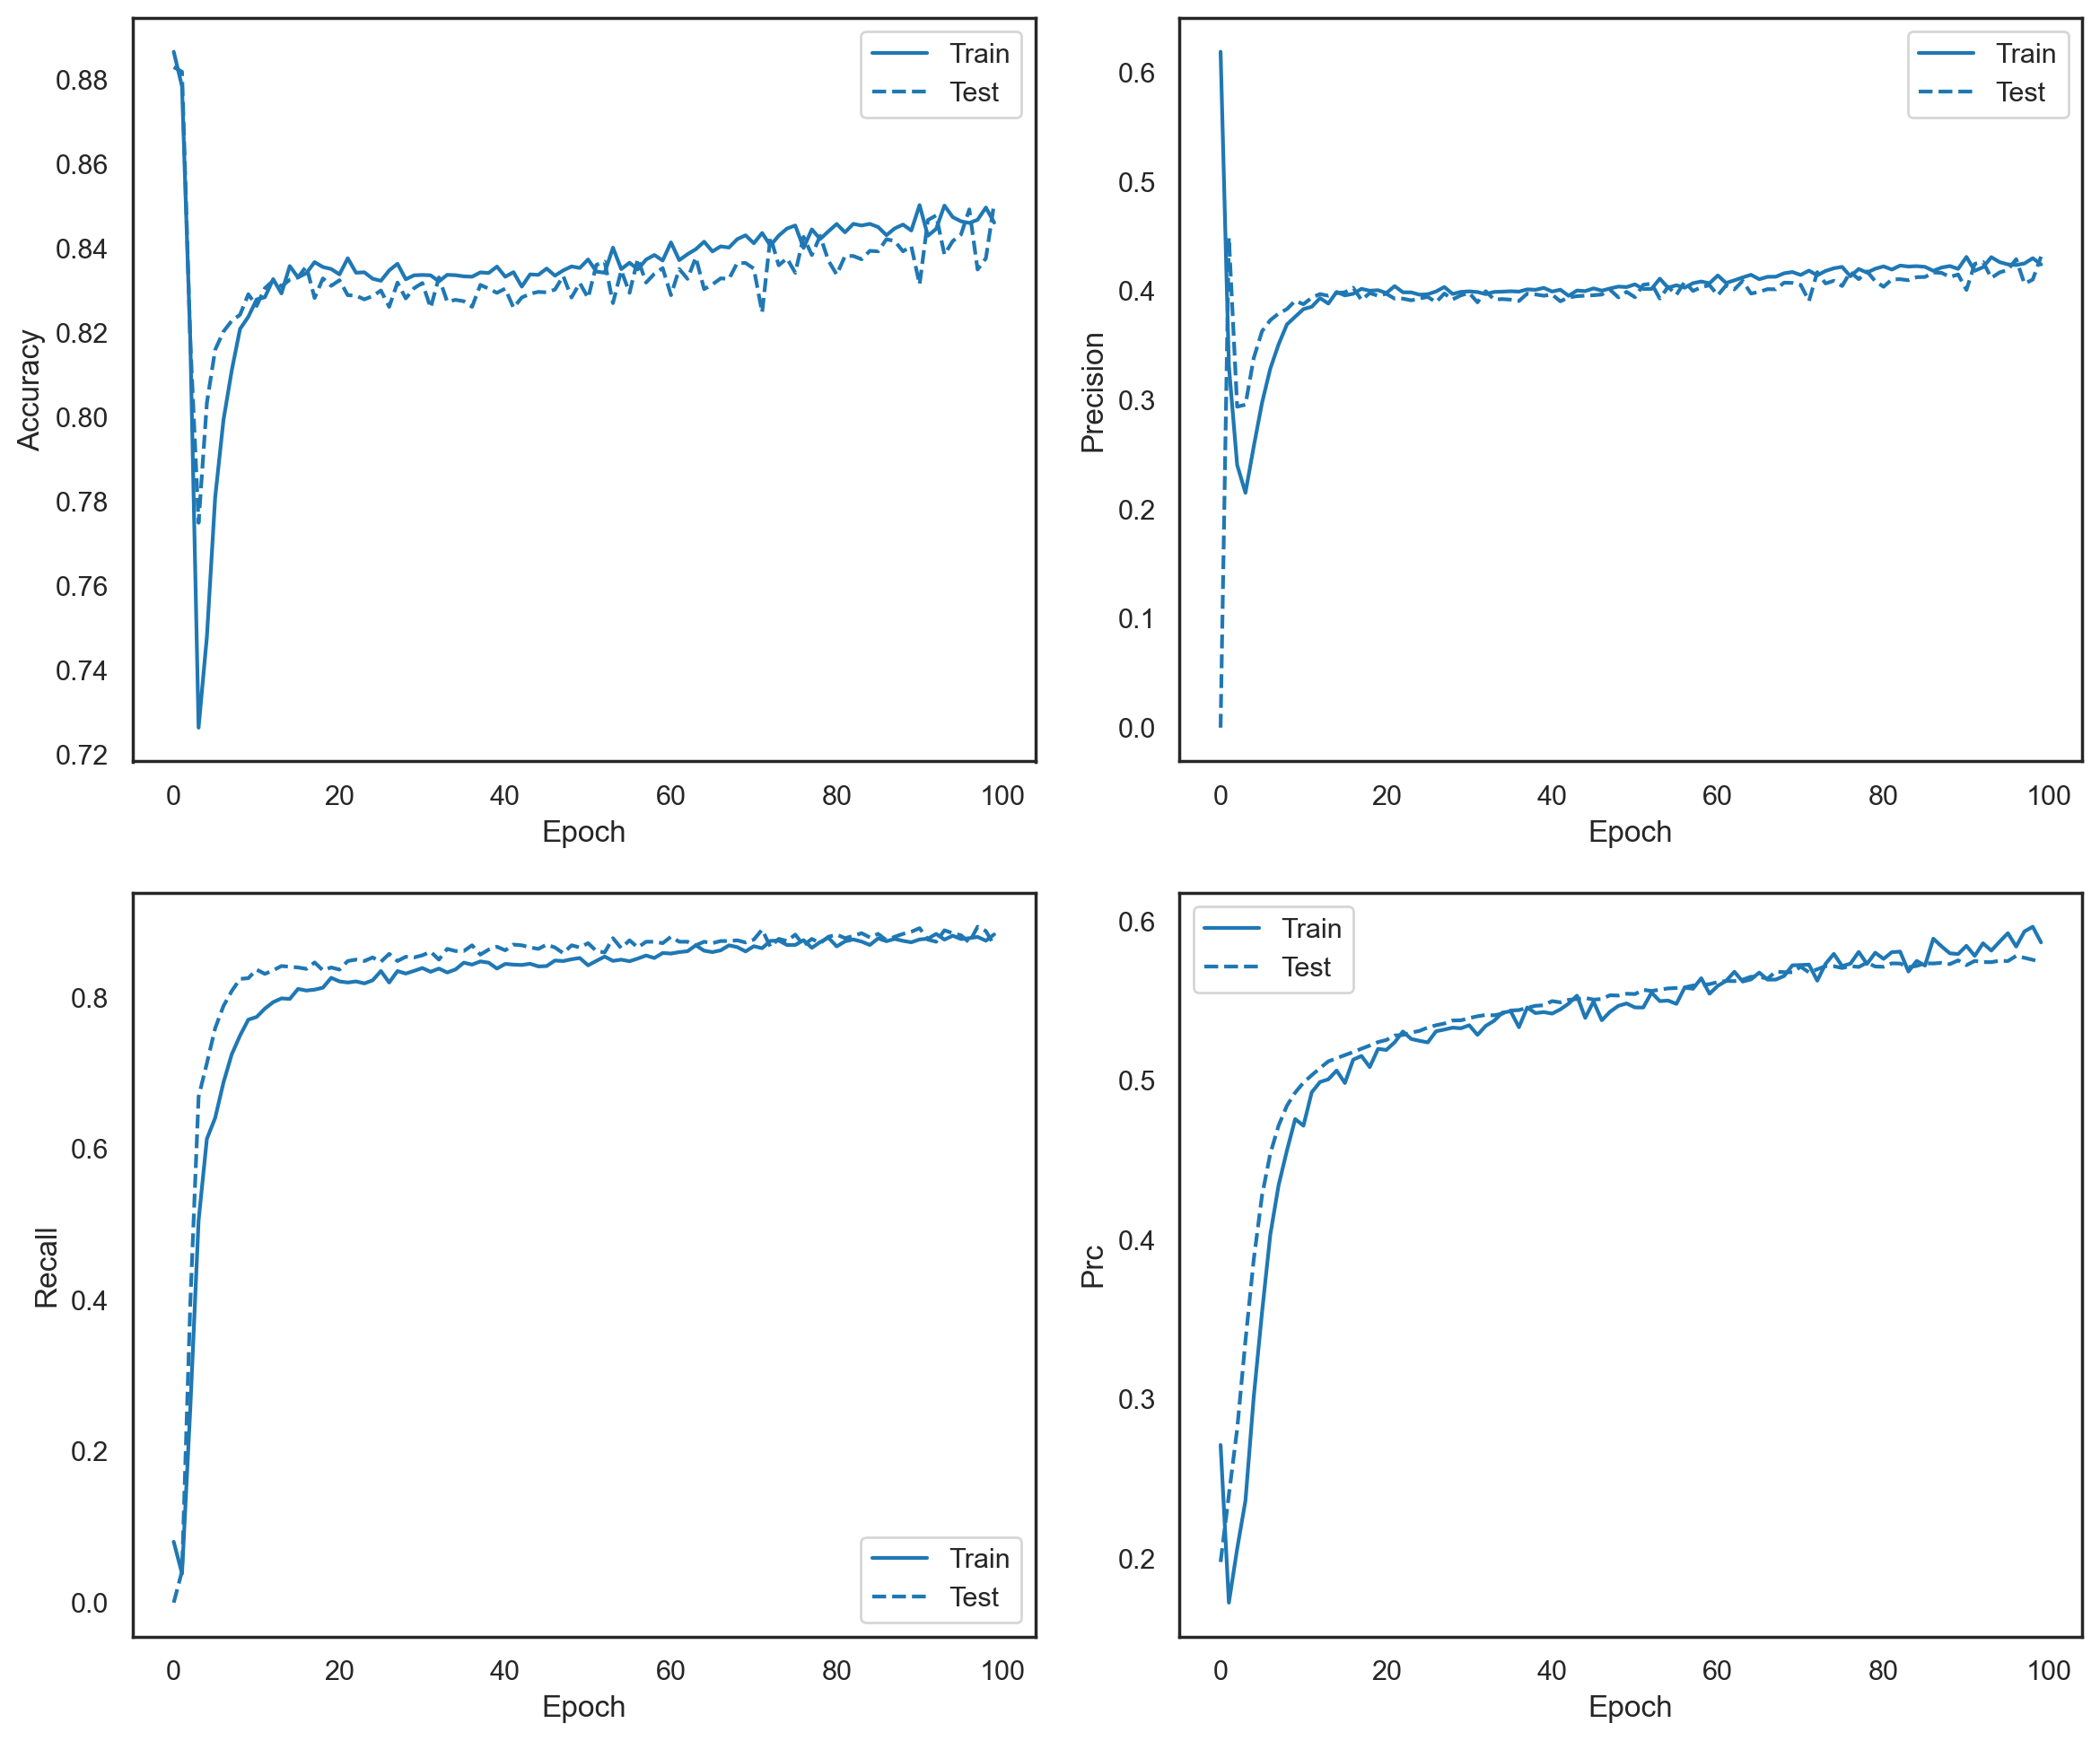

In [ ]:
plot_metrics(weighted_history)

In [ ]:
p = weighted_history.history['val_precision'][-1]
r = weighted_history.history['val_recall'][-1]
f1 = 2 * p * r / (p + r)
acc = weighted_history.history['val_accuracy'][-1]
weighted_result = f'weighted nn: precision={p:.2f}, recall={r:.2f}, f1={f1:.2f}, accuracy={acc:.2f}'
print(baseline_result)
print(weighted_result)

baseline nn: precision=0.62, recall=0.40, f1=0.49, accuracy=0.90
weighted nn: precision=0.43, recall=0.87, f1=0.58, accuracy=0.85


Compared to baseline nn, we definitely sacrificed accuracy and precision a lot to obtain a higher recall on the positive class.

# 6 - Resampling <a name='6'></a>

## naive random oversampling <a name='6.1'></a>

In [ ]:
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from collections import Counter

In [ ]:
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X_train1, y_train1)
print('before resample:', sorted(Counter(y_train1).items()))
print('after resample:', sorted(Counter(y_resampled).items()))

before resample: [(0, 22355), (1, 2962)]
after resample: [(0, 22355), (1, 22355)]


### lr on resampled data

In [ ]:
lr = LogisticRegression(max_iter=500)
lr_scores = cross_val_score(lr, X_resampled, y_resampled, scoring='f1', cv=5)
lr_scores.mean()

0.8325751366091483

In [ ]:
lr.fit(X_resampled, y_resampled)
y_test_pred = lr.predict(X_test_prepared)
print(classification_report(y_test, y_test_pred))
print(confusion_matrix(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.97      0.85      0.91      7985
           1       0.41      0.81      0.55      1058

    accuracy                           0.84      9043
   macro avg       0.69      0.83      0.73      9043
weighted avg       0.91      0.84      0.86      9043

[[6772 1213]
 [ 199  859]]


### xgb on resampled data

In [ ]:
xgb = XGBClassifier(eval_metric='logloss', use_label_encoder=False)
xgb_scores = cross_val_score(xgb, X_resampled, y_resampled, scoring='f1', cv=5)
xgb_scores.mean()

0.9403728179918067

In [ ]:
xgb.fit(X_resampled, y_resampled)
y_test_pred = xgb.predict(X_test_prepared)
print(classification_report(y_test, y_test_pred))
print(confusion_matrix(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.97      0.90      0.93      7985
           1       0.49      0.76      0.60      1058

    accuracy                           0.88      9043
   macro avg       0.73      0.83      0.76      9043
weighted avg       0.91      0.88      0.89      9043

[[7161  824]
 [ 253  805]]


Both overfitting the positive class, and not much improvement compared to unsampled result. Let's try other advanced sampling methods.

## random downsampling <a name='6.2'></a>

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(X_train_prepared, y_train)
print('before resample:', sorted(Counter(y_train).items()))
print('after resample:', sorted(Counter(y_resampled).items()))

before resample: [(0, 31937), (1, 4231)]
after resample: [(0, 4231), (1, 4231)]


### xgb on downsampled data

In [ ]:
xgb = XGBClassifier(eval_metric='logloss')
xgb.fit(X_resampled, y_resampled)
y_test_pred = xgb.predict(X_test_prepared)
print(classification_report(y_test, y_test_pred))
print(confusion_matrix(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.98      0.84      0.91      7985
           1       0.43      0.89      0.58      1058

    accuracy                           0.85      9043
   macro avg       0.71      0.87      0.74      9043
weighted avg       0.92      0.85      0.87      9043

[[6724 1261]
 [ 112  946]]


Downsampling doesn't help.

## SMOTE <a name='6.3'></a>

In [19]:
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X_train_prepared, y_train)
print('before resample:', sorted(Counter(y_train).items()))
print('after resample:', sorted(Counter(y_resampled).items()))

NameError: name 'SMOTE' is not defined

### xgb on SMOTE data

In [ ]:
xgb = XGBClassifier(eval_metric='logloss')
xgb.fit(X_resampled, y_resampled)
y_test_pred = xgb.predict(X_test_prepared)
print(classification_report(y_test, y_test_pred))
print(confusion_matrix(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.94      0.95      0.95      7985
           1       0.60      0.55      0.57      1058

    accuracy                           0.90      9043
   macro avg       0.77      0.75      0.76      9043
weighted avg       0.90      0.90      0.90      9043

[[7596  389]
 [ 476  582]]


Compared to xgb trained on the original dataset, the new result seems to have higher precision but lower recall on the positive class.

### nn on SMOTE data

In [18]:
resampled_model = build_model(num_features=train_features.shape[-1],
                              output_bias=np.log(pos/neg))
resampled_history = resampled_model.fit(
    X_resampled.toarray(),
    np.array(y_resampled),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(test_features, test_labels))

NameError: name 'build_model' is not defined

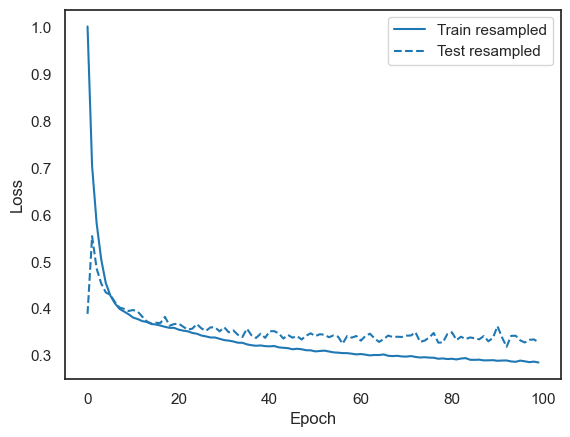

In [ ]:
plot_loss(resampled_history, 'resampled', n=1)

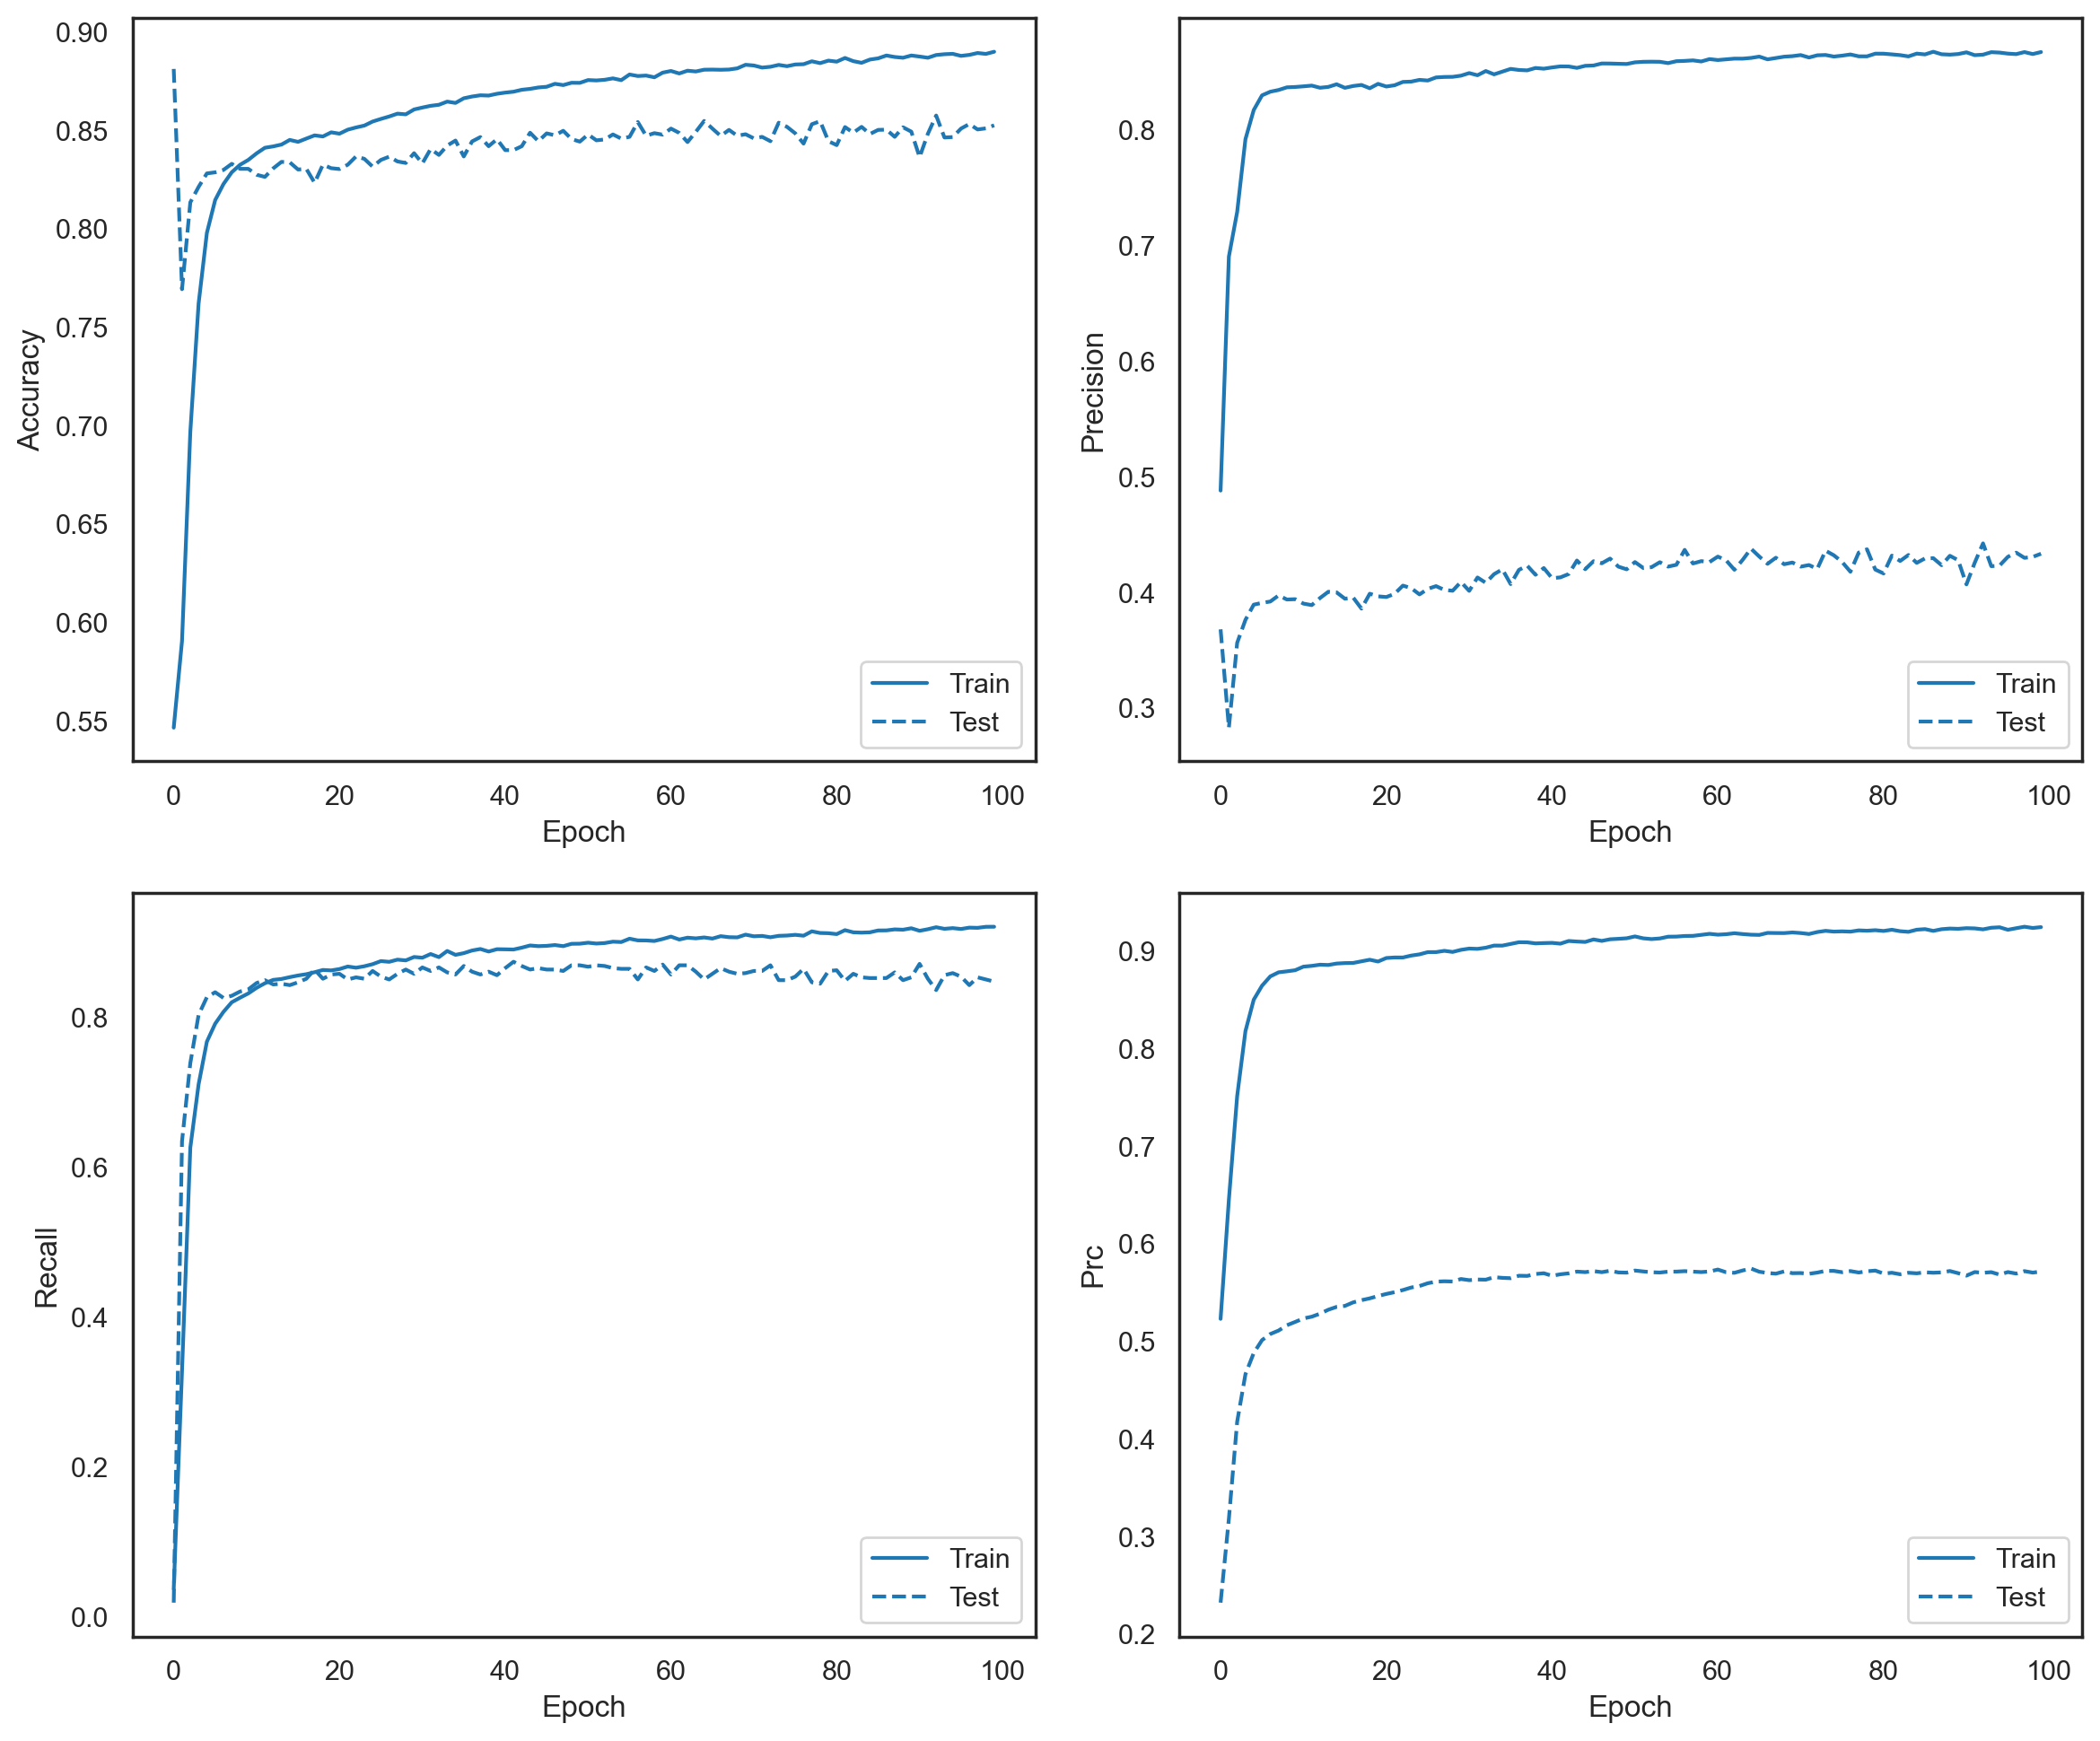

In [ ]:
plot_metrics(resampled_history)

In [ ]:
p = resampled_history.history['val_precision'][-1]
r = resampled_history.history['val_recall'][-1]
f1 = 2 * p * r / (p + r)
acc = resampled_history.history['val_accuracy'][-1]
resampled_result = f'resampled nn: precision={p:.2f}, recall={r:.2f}, f1={f1:.2f}, accuracy={acc:.2f}'
print(baseline_result)
print(weighted_result)
print(resampled_result)

baseline nn: precision=0.62, recall=0.40, f1=0.49, accuracy=0.90
weighted nn: precision=0.43, recall=0.87, f1=0.58, accuracy=0.85
resampled nn: precision=0.43, recall=0.85, f1=0.57, accuracy=0.85


## ADASYN

In [ ]:
adasyn = ADASYN()
X_resampled, y_resampled = adasyn.fit_resample(X_train_prepared, y_train)
print('before resample:', sorted(Counter(y_train).items()))
print('after resample:', sorted(Counter(y_resampled).items()))

before resample: [(0, 31937), (1, 4231)]
after resample: [(0, 31937), (1, 31822)]


### xgb on ADASYN resampled data

In [ ]:
xgb = XGBClassifier(eval_metric='logloss')
xgb.fit(X_resampled, y_resampled)
y_test_pred = xgb.predict(X_test_prepared)
print(classification_report(y_test, y_test_pred))
print(confusion_matrix(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.94      0.95      0.94      7985
           1       0.59      0.53      0.56      1058

    accuracy                           0.90      9043
   macro avg       0.76      0.74      0.75      9043
weighted avg       0.90      0.90      0.90      9043

[[7591  394]
 [ 497  561]]
